# Copmparing Sparse Regularization with Elastic Net with ILC Regularization

### Installations and imports

In [ ]:
!pip install -q git+git://github.com/deepmind/optax.git
!pip install -q git+https://github.com/deepmind/dm-haiku

     |████████████████████████████████| 51kB 4.3MB/s 


In [1]:
from typing import Any, Generator, Mapping, Tuple

from absl import app
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from optax._src import transform
from jax import jit, grad, vmap
from jax.tree_util import tree_structure

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import figure

### AND-mask optax class definition

In [2]:
class ANDMaskState(optax.OptState):
  """Stateless.""" # Following optax code style

def and_mask(agreement_threshold: float) -> optax.GradientTransformation:
  def init_fn(_):
    # Required by optax
    return ANDMaskState()

  def update_fn(updates, opt_state, params=None):

    def and_mask(update):
      # Compute the masked gradients for a single parameter tensor
      mask = jnp.abs(jnp.mean(jnp.sign(update), 0)) >= agreement_threshold
      mask = mask.astype(jnp.float32)
      avg_update = jnp.mean(update, 0)
      mask_t = mask.sum() / mask.size
      update = mask * avg_update * (1. / (1e-10 + mask_t))
      return update

    del params # Following optax code style
    
    # Compute the masked gradients over all parameters

    # jax.tree_map maps a function (lambda function in this case) over a pytree to produce a new pytree.
    updates = jax.tree_map(lambda x: and_mask(x), updates)
    return updates, opt_state

  return transform.GradientTransformation(init_fn, update_fn)

In [3]:
X_1 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V1/X/*.npy").as_numpy_iterator())
X_2 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V2/X/*.npy").as_numpy_iterator())
X_3 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V3/X/*.npy").as_numpy_iterator())

In [4]:
y_1 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V1/y/*.npy").as_numpy_iterator())
y_2 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V2/y/*.npy").as_numpy_iterator())
y_3 = list(tf.data.Dataset.list_files("/Users/iDev/repos/pgm-fmri/data/V3/y/*.npy").as_numpy_iterator())

In [5]:
tmp = np.load(X_1[0])
tmp.shape

(300, 53, 63, 52)

In [6]:
tmp = np.load(y_1[0])
tmp.shape

(300,)

In [7]:
V1_X = np.zeros((len(X_1), 300, 53, 63, 52))
V2_X = np.zeros((len(X_2), 300, 53, 63, 52))
V3_X = np.zeros((len(X_3), 300, 53, 63, 52))

In [8]:
V1_y = np.zeros((len(y_1), 300))
V2_y = np.zeros((len(y_2), 300))
V3_y = np.zeros((len(y_3), 300))

In [9]:
for i in range(len(X_1)):
    index = int(X_1[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V1_X[index-1] = np.load(X_1[i])
    index = int(y_1[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V1_y[index-1] = np.load(y_1[i])

In [10]:
for i in range(len(X_2)):
    index = int(X_2[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V2_X[index-1] = np.load(X_2[i])
    index = int(y_2[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V2_y[index-1] = np.load(y_2[i])

In [11]:
for i in range(len(X_3)):
    index = int(X_3[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V3_X[index-1] = np.load(X_3[i])
    index = int(y_3[i].decode("utf-8").split('/')[-1].split('.')[0].split('_')[-1])
    V3_y[index-1] = np.load(y_3[i])

In [12]:
V1_X.shape

(2, 300, 53, 63, 52)

In [13]:
V1_y.shape

(2, 300)

In [23]:
V1_X = V1_X.reshape(-1,53, 63, 52)
V2_X = V2_X.reshape(-1,53, 63, 52)
V3_X = V3_X.reshape(-1,53, 63, 52)

In [35]:
V1_y = V1_y.reshape(-1)
V2_y = V2_y.reshape(-1)
V3_y = V3_y.reshape(-1)

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices({'X': V1_X, 'y': V1_y})
test_dataset = tf.data.Dataset.from_tensor_slices({'X': V2_X, 'y': V2_y})

In [37]:
BATCH_SIZE = 50
SHUFFLE_BUFFER_SIZE = 100
OptState = Any
Batch = Mapping[str, np.ndarray]
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [38]:
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
    dataset
    ) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = dataset.cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(ds.as_numpy_iterator())

In [39]:
train = load_dataset("train", is_training=True, batch_size=50, dataset=train_dataset)
train_eval = load_dataset("train", is_training=False, batch_size=50, dataset=train_dataset)
test_eval = load_dataset("test", is_training=False, batch_size=50, dataset=test_dataset)

## Preliminary Experiments with MNIST. Could be skipped.

### MNIST Classification: Layers:(input, 500, 500, 10), (Optional) Regularizer: Yes, ILC: Yes

In [20]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(500), jax.nn.relu, # 300
      hk.Linear(500), jax.nn.relu, # 1000
      hk.Linear(10),
  ])
  return mlp(x)


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.8
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

    
# Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # # L1 Loss
    # sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    # sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    # l1_loss = sum(sum_p_layers)

    # # L2 Loss
    # l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent # + 1e-4 * l2_loss + 1e-5 * l1_loss

    
# Regularization loss (L1,L2).
def regularization_loss(params: hk.Params) -> jnp.ndarray:
    """Compute the regularization loss of the network, applied after ILC."""

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    return 1e-4 * l2_loss + 1e-5 * l1_loss

@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)


# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads_masked = (gradient_per_sample)(params, batch, label)
    sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,jax.grad(regularization_loss)(params))
    grads = sum_grad_masked_regularized
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
    
# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=50, dataset=train_dataset)
train_eval = load_dataset("train", is_training=False, batch_size=50, dataset=train_dataset)
test_eval = load_dataset("test", is_training=False, batch_size=50, dataset=test_dataset)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['X'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['X'], Batch['y'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['X'], Batch['y'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['X'], Batch['y'])
    avg_params = ema_update(avg_params, params)

KeyboardInterrupt: 

### Sparse Logistic Regression with MNIST (Only the NN architecture differs from the above cell)

In [40]:
"""MNIST classifier example."""


OptState = Any
Batch = Mapping[str, np.ndarray]


def net_fn(batch) -> jnp.ndarray:
  
  x = jnp.array(batch, jnp.float32) / 255.
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(10),
  ])
  return mlp(x)


# Make the network and optimiser.
net = hk.without_apply_rng(hk.transform(net_fn))
# opt = optax.adam(1e-3)
agreement_threshold = 0.7
use_ilc = True
opt = optax.chain(and_mask(agreement_threshold),optax.adam(1e-3)
    # ,optax.scale_by_adam()
    )

   
# Training loss (cross-entropy).
def loss(params: hk.Params, batch, label) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(label, 10)

    # # L1 Loss
    # sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    # sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    # l1_loss = sum(sum_p_layers)

    # # L2 Loss
    # l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    # Cross Entropy Loss
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]
    return softmax_xent # + 1e-4 * l2_loss + 1e-5 * l1_loss

    
# Regularization loss (L1,L2).
def regularization_loss(params: hk.Params) -> jnp.ndarray:
    """Compute the regularization loss of the network, applied after ILC."""

    # L1 Loss
    sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
    sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
    l1_loss = sum(sum_p_layers)

    # L2 Loss
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    return 1e-4 * l2_loss + 1e-5 * l1_loss


@jax.jit
def gradient_per_sample(params, batch, label):
    batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
    return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

gradient = jax.jit(grad(loss))

# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == label)

@jax.jit
def update(
      params: hk.Params,
      opt_state: OptState,
      batch, label
    ) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # grads = jax.grad(loss)(params, batch, label)
    grads_masked = (gradient_per_sample)(params, batch, label)
    sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,jax.grad(regularization_loss)(params))
    grads = sum_grad_masked_regularized
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
    

# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation.
# For more, see: https://doi.org/10.1137/0330046
@jax.jit
def ema_update(
      avg_params: hk.Params,
      new_params: hk.Params,
      epsilon: float = 0.001,
  ) -> hk.Params:
    return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                             avg_params, new_params)

# Make datasets.
train = load_dataset("train", is_training=True, batch_size=50, dataset=train_dataset)
train_eval = load_dataset("train", is_training=False, batch_size=50, dataset=train_dataset)
test_eval = load_dataset("test", is_training=False, batch_size=50, dataset=test_dataset)

# Initialize network and optimiser; note we draw an input to get shapes.
params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['X'])
opt_state = opt.init(params)

# print(jax.grad(loss)(params, next(train)))

# Train/eval loop.
for step in range(10001):
    if step % 1000 == 0:
      # Periodically evaluate classification accuracy on train & test sets.
      Batch = next(train_eval)
      train_accuracy = accuracy(avg_params, Batch['X'], Batch['y'])
      Batch = next(test_eval)
      test_accuracy = accuracy(avg_params, Batch['X'], Batch['y'])
      train_accuracy, test_accuracy = jax.device_get(
          (train_accuracy, test_accuracy))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

    # Do SGD on a batch of training examples.

    Batch = next(train)
    params, opt_state = update(params, opt_state, Batch['X'], Batch['y'])

    avg_params = ema_update(avg_params, params)

[Step 0] Train / Test accuracy: 0.000 / 0.000.
[Step 1000] Train / Test accuracy: 0.480 / 1.000.


KeyboardInterrupt: 

## Experiments and Plots related to our hypothesis

### Sparse Logistic Regression Function (For reusability)

In [ ]:
OptState = Any

Batch = Mapping[str, np.ndarray]

def sparse_logistic_regression(train=None, test=None, adam_lr=1e-3, agreement_threshold=0.0,
                               use_ilc=False, l1_coef=1e-5, l2_coef=1e-4,
                               epochs=10001, Verbose=False, n_classes=6, normalizer=255., training=True):


    training_accs = []
    testing_accs = []

    def net_fn(batch) -> jnp.ndarray:
    
        x = jnp.array(batch, jnp.float32) / normalizer
        mlp = hk.Sequential([
            hk.Flatten(),
            hk.Linear(n_classes),
        ])
        return mlp(x)


    # Make the network and optimiser.
    net = hk.without_apply_rng(hk.transform(net_fn))

       
    # Training loss (cross-entropy).
    def loss(params: hk.Params, batch, label) -> jnp.ndarray:
        """Compute the loss of the network, including L2."""
        logits = net.apply(params, batch)
        labels = jax.nn.one_hot(label, n_classes)

        # Cross Entropy Loss
        softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
        softmax_xent /= labels.shape[0]
        return softmax_xent 

        
    # Regularization loss (L1,L2).
    def regularization_loss(params: hk.Params) -> jnp.ndarray:
        """Compute the regularization loss of the network, applied after ILC."""

        # L1 Loss
        sum_in_layer = lambda p: jnp.sum(jnp.abs(p))
        sum_p_layers = [sum_in_layer(p) for p in jax.tree_leaves(params)]
        l1_loss = sum(sum_p_layers)

        # L2 Loss
        l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

        return l2_coef * l2_loss + l1_coef * l1_loss
    

    @jax.jit
    def gradient_per_sample(params, batch, label):
        batch, label = jnp.expand_dims(batch,1), jnp.expand_dims(label,1)
        return vmap(grad(loss), in_axes=(None, 0, 0))(params, batch, label)

    gradient = jax.jit(grad(loss))
    gradient_reg = jax.jit(grad(regularization_loss))

    # Evaluation metric (classification accuracy).
    @jax.jit
    def accuracy(params: hk.Params, batch, label) -> jnp.ndarray:
        predictions = net.apply(params, batch)
        return jnp.mean(jnp.argmax(predictions, axis=-1) == label)
   
    @jax.jit
    def update(
        params: hk.Params,
        opt_state: OptState,
        batch, label, agreement
        ) -> Tuple[hk.Params, OptState]:
        """Learning rule (stochastic gradient descent)."""
        # grads = jax.grad(loss)(params, batch, label)
        # grads_masked = (gradient_per_sample if use_ilc else gradient)(params, batch, label) # (gradient_per_sample)(params, batch, label)
        # sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,grads_masked,gradient_reg(params))
        # grads = sum_grad_masked_regularized
        # updates, opt_state = opt.update(grads, opt_state)
        # new_params = optax.apply_updates(params, updates)

        grads_samples = gradient_per_sample(params, batch, label)
        ANDmask = and_mask(agreement)

        masked_grads,_ = ANDmask.update(grads_samples, opt_state)
        reg_grads = gradient_reg(params)

        sum_grad_masked_regularized = jax.tree_multimap(lambda x,y:x+y,masked_grads,reg_grads)
 
        updates,_ = opt.update(sum_grad_masked_regularized, opt_state)

        new_params = optax.apply_updates(params, updates)

        return new_params, opt_state


    # We maintain avg_params, the exponential moving average of the "live" params.
    # avg_params is used only for evaluation.
    # For more, see: https://doi.org/10.1137/0330046
    @jax.jit
    def ema_update(
        avg_params: hk.Params,
        new_params: hk.Params,
        epsilon: float = 0.001,
    ) -> hk.Params:
        return jax.tree_multimap(lambda p1, p2: (1 - epsilon) * p1 + epsilon * p2,
                                avg_params, new_params)


    if training is False:
        return net, accuracy
    else:

        if use_ilc:

            use_ilc = False

            opt = optax.chain(optax.adam(adam_lr)
                # ,optax.scale_by_adam()
                )
            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(train)['image'])
            opt_state = opt.init(params)

            # opt = optax.chain(and_mask(agreement_threshold) if use_ilc else optax.identity(),optax.adam(adam_lr))
            # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used

            # Train/eval loop. WITHOUT ILC
            print("Begin training with ILC")
            for step in range(np.int(.5*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ILC Off, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch['image'], Batch['label'], 0.)
                avg_params = ema_update(avg_params, params)

            
            use_ilc = True

            # Train/eval loop. WITH ILC
            for step in range(np.int(.5*epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ILC On, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")

                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch['image'], Batch['label'], agreement_threshold)
                avg_params = ema_update(avg_params, params)

            return params, training_accs, testing_accs

        else:

             # schedule_fn = optax.exponential_decay(adam_lr, # Note the minus sign!
            # 1,
            # 0.9)
            # opt = optax.chain(optax.sgd(adam_lr), optax.scale_by_schedule(schedule_fn)) # Or Adam could be used
            opt = optax.chain(optax.adam(adam_lr))

            # Initialize network and optimiser; note we draw an input to get shapes.
            params = avg_params = net.init(jax.random.PRNGKey(42), next(train)[0])
            opt_state = opt.init(params)

            use_ilc=False

            # Train/eval loop. 
            print("Begin training without ILC")
            for step in range(np.int(epochs)):
                if step % np.int(epochs/10) == 0:
                    # Periodically evaluate classification accuracy on train & test sets.
                    Batch = next(train)
                    train_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    train_accuracy = jax.device_get(train_accuracy)
                    Batch = next(test)
                    test_accuracy = accuracy(avg_params, Batch['image'], Batch['label'])
                    test_accuracy = jax.device_get(test_accuracy)
                    training_accs.append(train_accuracy)
                    testing_accs.append(test_accuracy)
                    if Verbose:
                        print(f"[ADAM, Step {step}] Train accuracy/Test accuracy: "
                                f"{train_accuracy:.3f} / {test_accuracy:.3f}.")
                        
                # Do SGD on a batch of training examples.
                Batch = next(train)
                params, opt_state = update(params, opt_state, Batch['image'], Batch['label'], 0.)
                avg_params = ema_update(avg_params, params)
            
            return params, training_accs, testing_accs


### Storing the resulting weights for various hyperparameters, for plotting and exploratory purposes. Change the name when you store a parameter accordingly.

In [ ]:
import pickle
root_dir = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

def storeData(object, file_name, root_dir):
    with open(root_dir+file_name, 'wb') as f:
        pickle.dump(object, f)					 
        f.close() 

def loadData(file_name, root_dir): 
    with open(root_dir+file_name, 'rb') as f:
        db = pickle.load(f) 
        f.close()
        return db

# storeData(envs_elastic_net_params, 'envs_elastic_net_params', root_dir)
# storeData(envs_ilc_params, 'envs_ilc_params_l24_agth_09_late_turn_on_ilc_before_reg', root_dir)


# envs_elastic_net_params = loadData('envs_elastic_net_params_l14_l25', root_dir)
# envs_ilc_params = loadData('envs_ilc_params_l24_agth_03', root_dir)

# storeData(setting_overlaps, 'setting_overlaps', root_dir)
storeData(hps_combined, 'all_hps_run54_modified', root_dir)
# setting_overlaps = loadData('setting_overlaps', root_dir)
# all_hps = loadData('all_hps', root_dir)

In [ ]:
# print(all_hps)
# print(all_hps_2)
# hps_combined = []
hps_combined = all_hps + all_hps_2
# hps_combined.append(all_hps_2)
# print(len(hps_combined))
# print(hps_combined)
all = hps_combined
print(all[1]['testing_accuracies'][0][-1])

0.1017


In [ ]:
model, accuracy_fn = sparse_logistic_regression(training=False)

test_ds = tfds.load("mnist:3.*.*", split='test').cache()
test_ds = test_ds.shuffle(10 * 10000, seed=0)
test_ds = test_ds.batch(10000)
test_ds= iter(tfds.as_numpy(test_ds))
Batch = next(test_ds)
batch, label = Batch['image'], Batch['label']
for setting in all_hps:
    setting['test_accuracy'] = []
    test_acc_env_1 = accuracy_fn(setting['params'][0], batch, label)
    setting['test_accuracy'].append(test_acc_env_1)
    test_acc_env_2 = accuracy_fn(setting['params'][1], batch, label)
    setting['test_accuracy'].append(test_acc_env_2)

    setting['test_accuracy_avg'] = []
    test_acc_avg = (test_acc_env_1+test_acc_env_2)/2.
    setting['test_accuracy_avg'].append(test_acc_avg)

# print(jax.device_get(all_hps[5]['test_accuracy_avg']))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


NameError: ignored

In [ ]:
# NOTE: "all_hps", and "setting_overlaps" should be loaded from your local drive
# (I uploaded them along with the zip file)

import pickle
root_dir = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/'

def storeData(object, file_name, root_dir):
    with open(root_dir+file_name, 'wb') as f:
        pickle.dump(object, f)					 
        f.close() 

def loadData(file_name, root_dir): 
    with open(root_dir+file_name, 'rb') as f:
        db = pickle.load(f) 
        f.close()
        return db

# storeData(setting_overlaps, 'setting_overlaps', root_dir)

all_hps = all
storeData(all_hps, 'all_hps', root_dir)

# setting_overlaps = loadData('setting_overlaps', root_dir)
# all_hps = loadData('all_hps', root_dir)

### MAIN CELL: Experimenting a range of hyperparameters

In [ ]:
# at = [0.2, 0.9]
# ll1 = [1e-3]
# ll2 = [1e-3, 1e-4]
# all = []
# at = [0.0, 0.2, 0.4, 0.5, 0.7, 0.9]
# at = [0.5, 0.7, 0.9]
# ll1 = [1e-1, 1e-2, 1e-3]
# ll2 = [1e-3, 1e-4, 1e-5]
at = [0.0, 0.5, 0.9]
ll1 = [1e-1, 1e-2, 1e-3]
ll2 = [1e-1, 1e-2, 1e-3]
all = []
n_envs = 2
ds_train_envs = []
batch_size = 10000
splits = tfds.even_splits('train', n=n_envs)
for m in range(n_envs):
    ds = tfds.load("mnist:3.*.*", split=splits[m]).cache().repeat()
    ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    ds_train_envs.append(iter(tfds.as_numpy(ds)))

test_ds = tfds.load("mnist:3.*.*", split='test').cache().repeat()
test_ds = test_ds.shuffle(10 * 10000, seed=0)
test_ds = test_ds.batch(10000)
test_ds= iter(tfds.as_numpy(test_ds))

round = 0
for idx, thresh in enumerate(at):
  for l1 in ll1:
    for l2 in ll2:
      round += 1
      print('Round: ', round)

      envs_elastic_net_params = []
      hp = {}
      hp['thresh'] = thresh
      hp['l1'] = l1
      hp['l2'] = l2
      hp['params'] = []
      hp['training_accuracies'] = []
      hp['testing_accuracies'] = []
      for m in range(n_envs):
        print('Parameters=[l1={}, l2={}, agreement={}], Environment={}'.format(l1,l2,thresh, m))
        params, train_accs, test_accs = sparse_logistic_regression(ds_train_envs[m], test_ds, adam_lr=1e-3, agreement_threshold=thresh,
                                  use_ilc=True, l1_coef=l1, l2_coef=l2,
                                  epochs=10001, Verbose=True)
        envs_elastic_net_params.append(params)
        hp['params'].append(params)
        hp['training_accuracies'].append(train_accs)
        hp['testing_accuracies'].append(test_accs)
      all.append(hp)

6
all_hps = all
storeData(all_hps, 'all_hps_3', root_dir)

Round:  1
Parameters=[l1=0.1, l2=0.1, agreement=0.0], Environment=0
Begin training with ILC
[ILC Off, Step 0] Train accuracy/Test accuracy: 0.063 / 0.064.
[ILC Off, Step 1000] Train accuracy/Test accuracy: 0.066 / 0.067.
[ILC Off, Step 2000] Train accuracy/Test accuracy: 0.064 / 0.065.
[ILC Off, Step 3000] Train accuracy/Test accuracy: 0.058 / 0.062.
[ILC Off, Step 4000] Train accuracy/Test accuracy: 0.061 / 0.064.
[ILC On, Step 0] Train accuracy/Test accuracy: 0.081 / 0.081.
[ILC On, Step 1000] Train accuracy/Test accuracy: 0.095 / 0.100.
[ILC On, Step 2000] Train accuracy/Test accuracy: 0.107 / 0.106.
[ILC On, Step 3000] Train accuracy/Test accuracy: 0.105 / 0.105.
[ILC On, Step 4000] Train accuracy/Test accuracy: 0.101 / 0.100.
Parameters=[l1=0.1, l2=0.1, agreement=0.0], Environment=1
Begin training with ILC
[ILC Off, Step 0] Train accuracy/Test accuracy: 0.060 / 0.066.
[ILC Off, Step 1000] Train accuracy/Test accuracy: 0.058 / 0.068.
[ILC Off, Step 2000] Train accuracy/Test accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

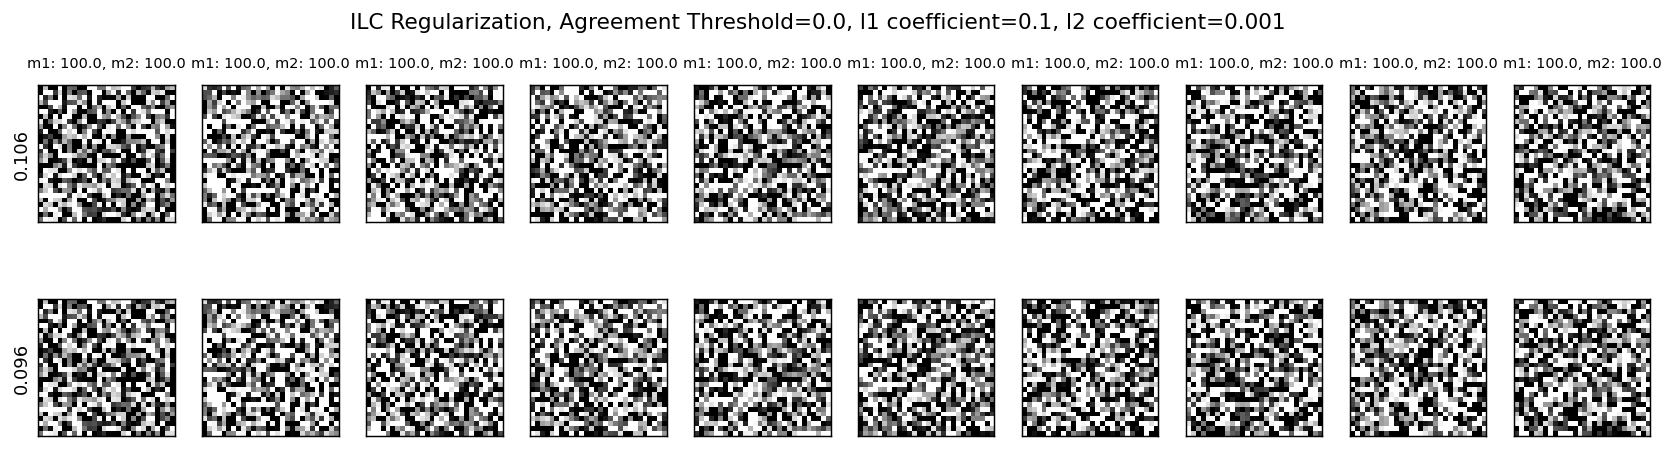

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

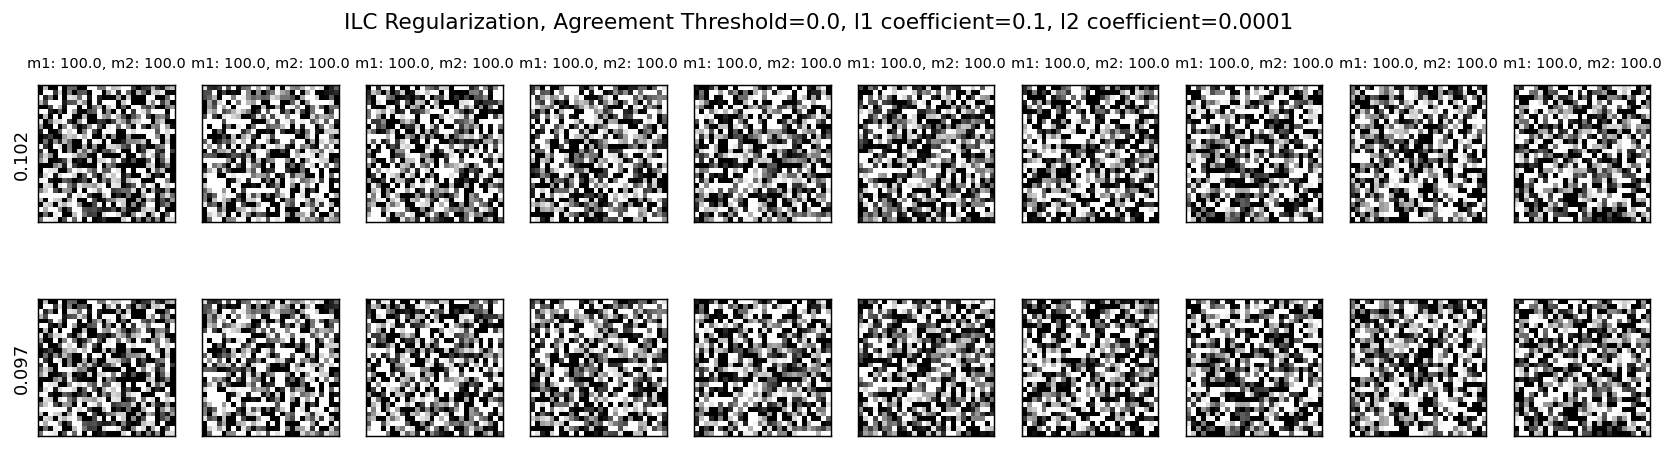

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

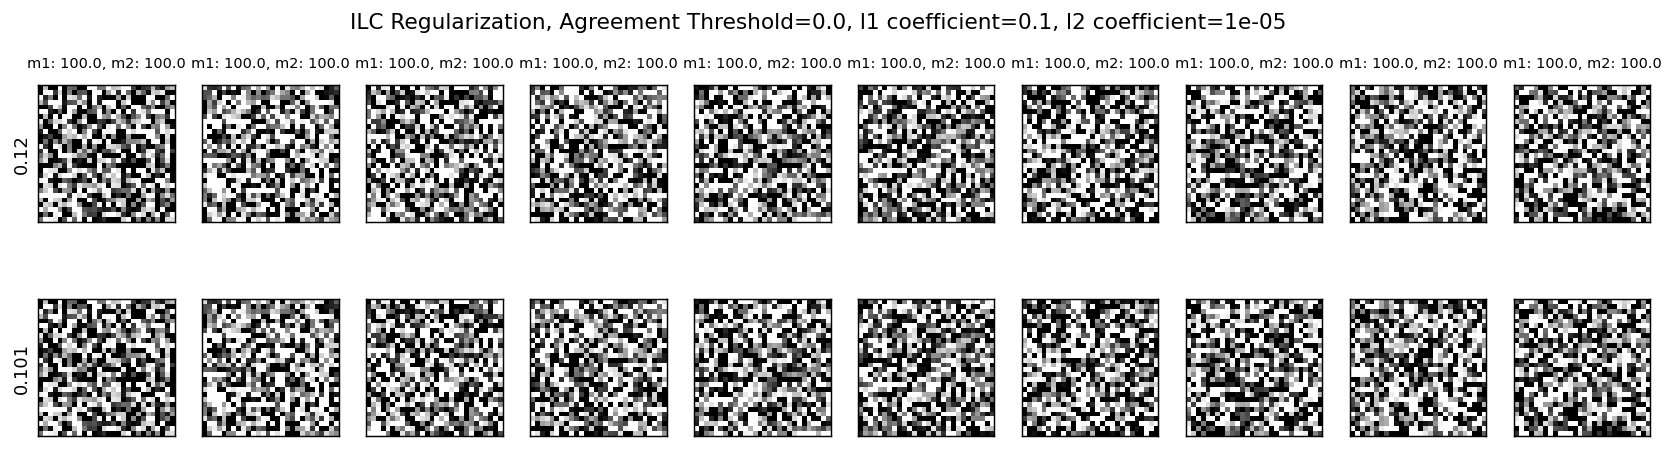

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

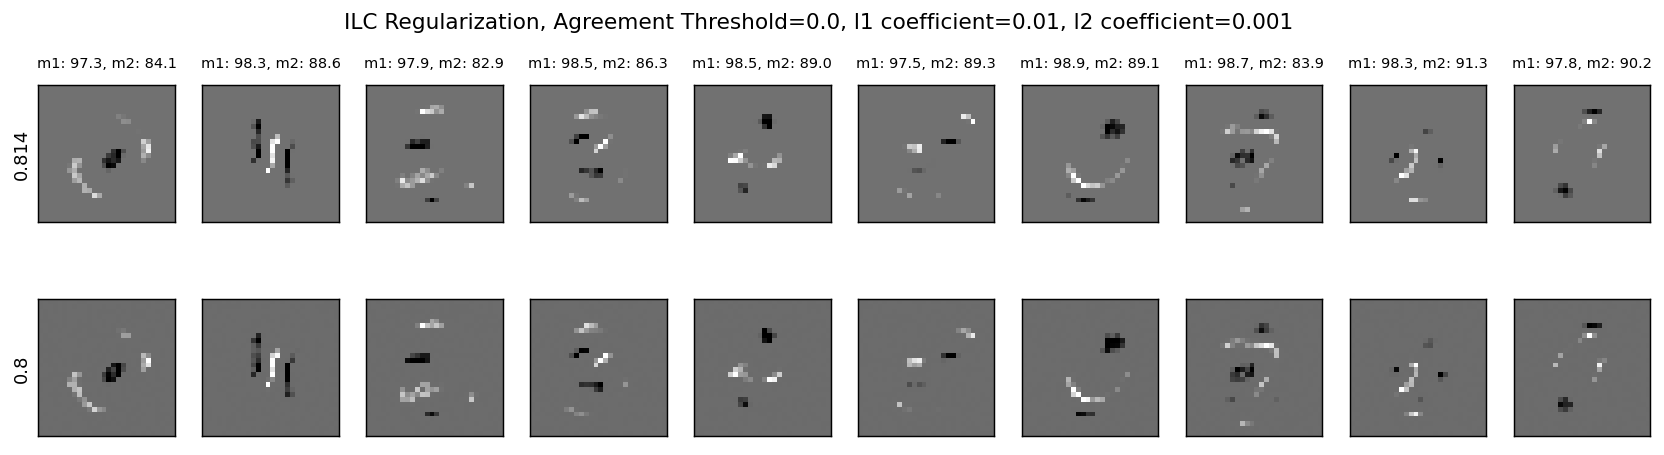

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

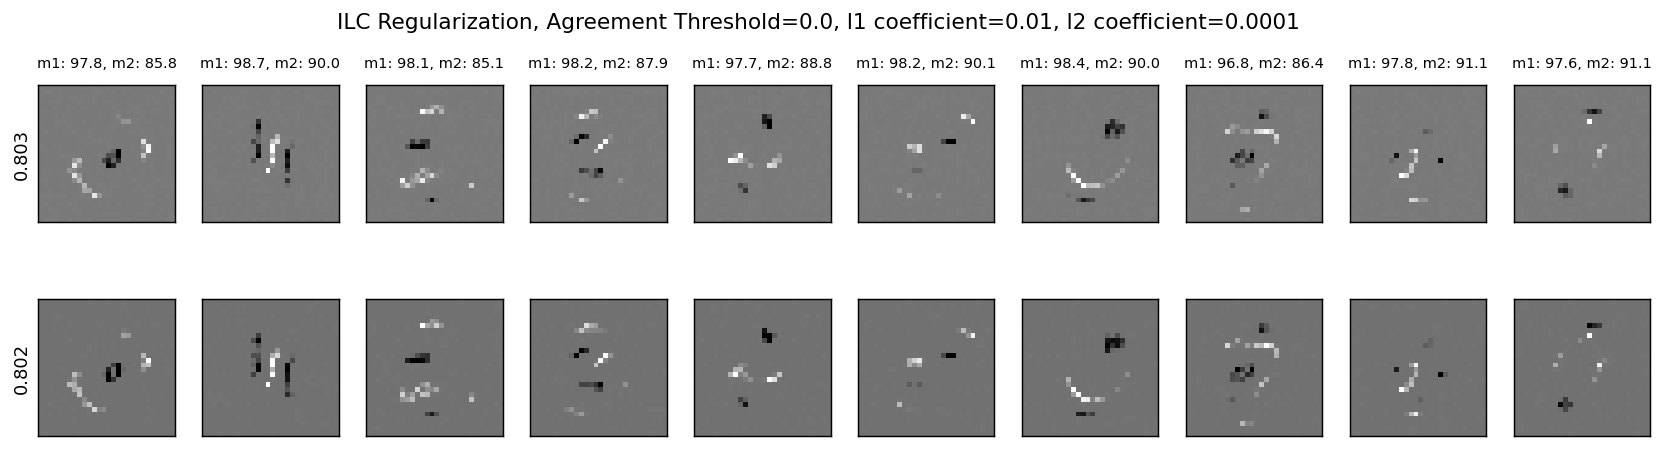

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

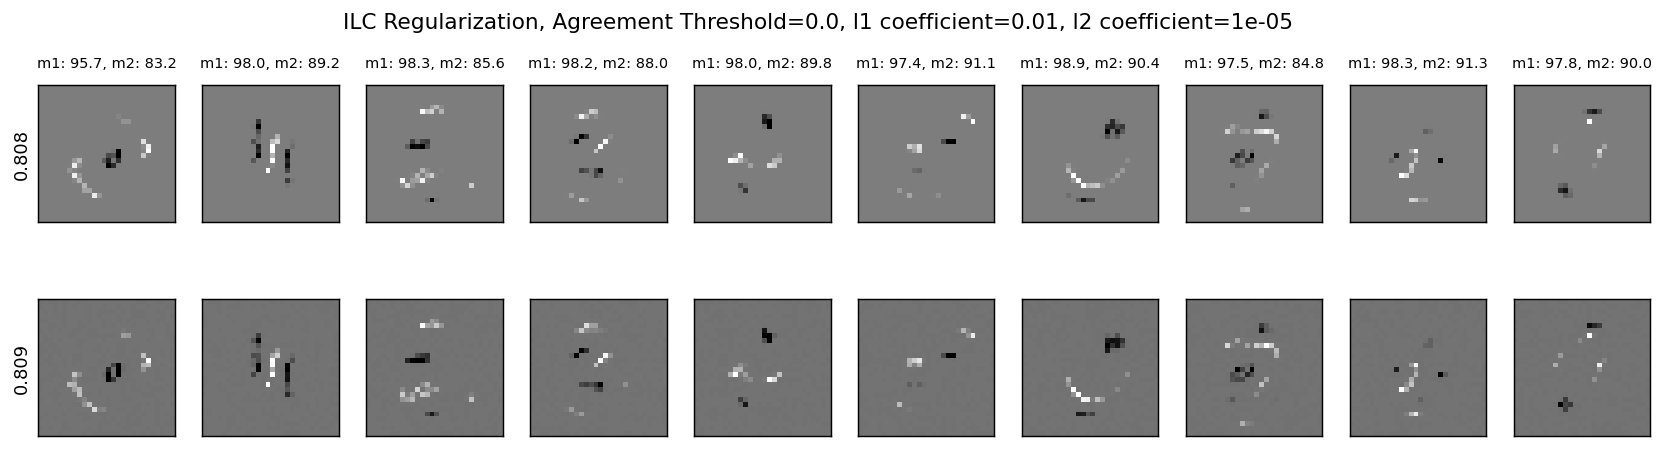

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

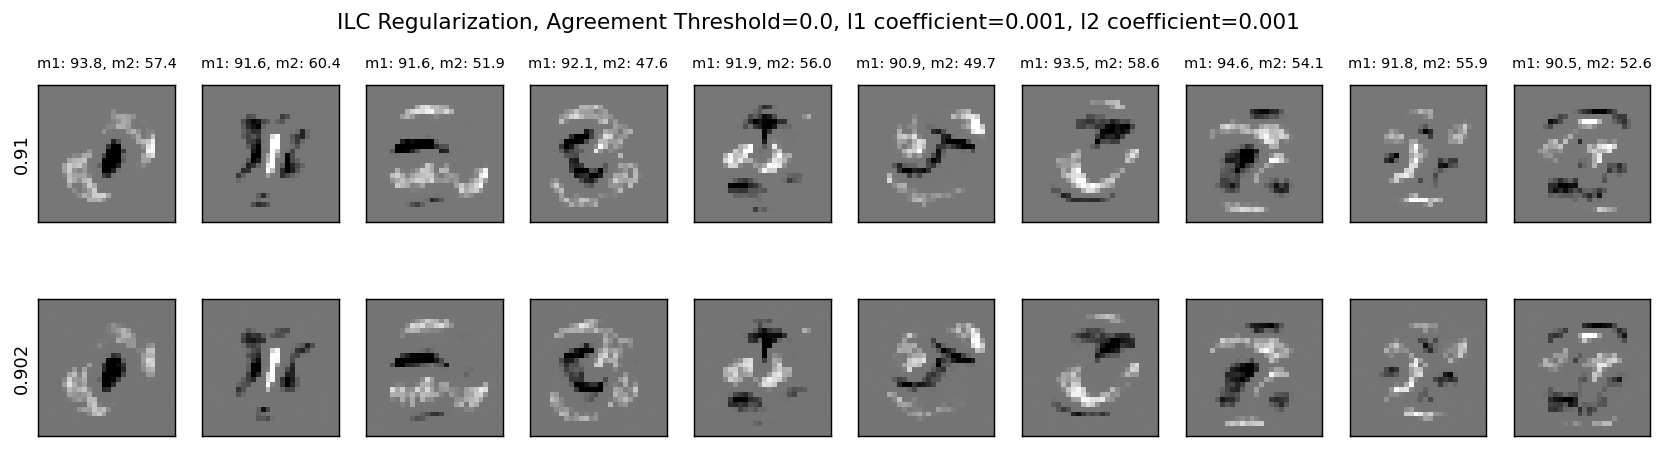

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

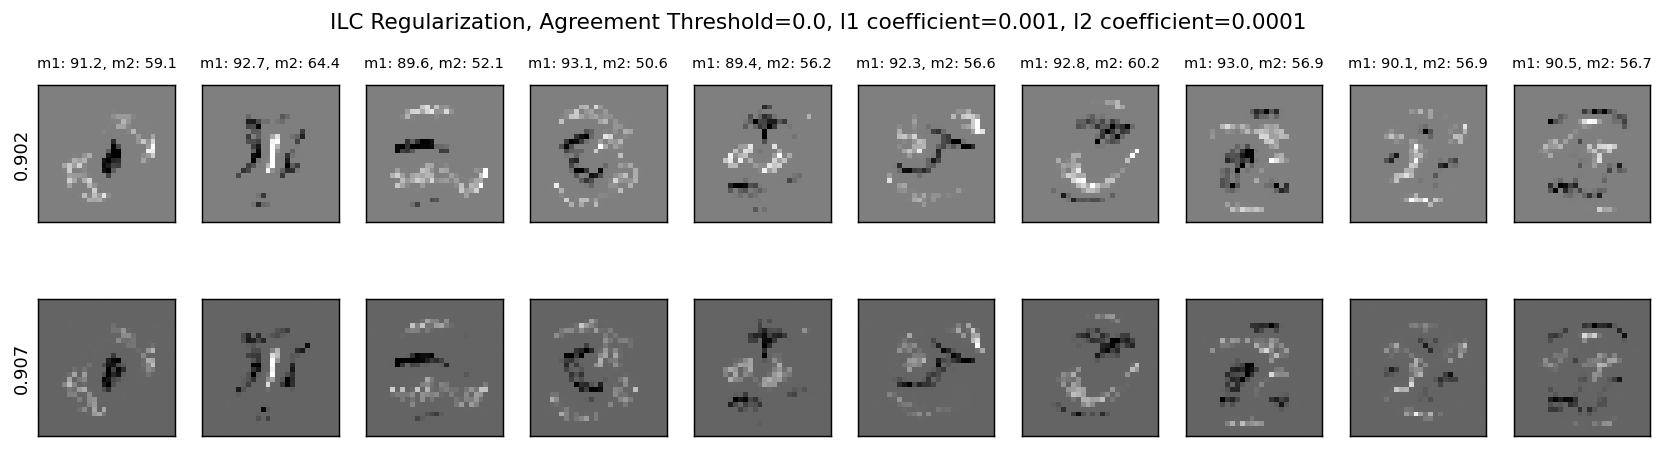

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

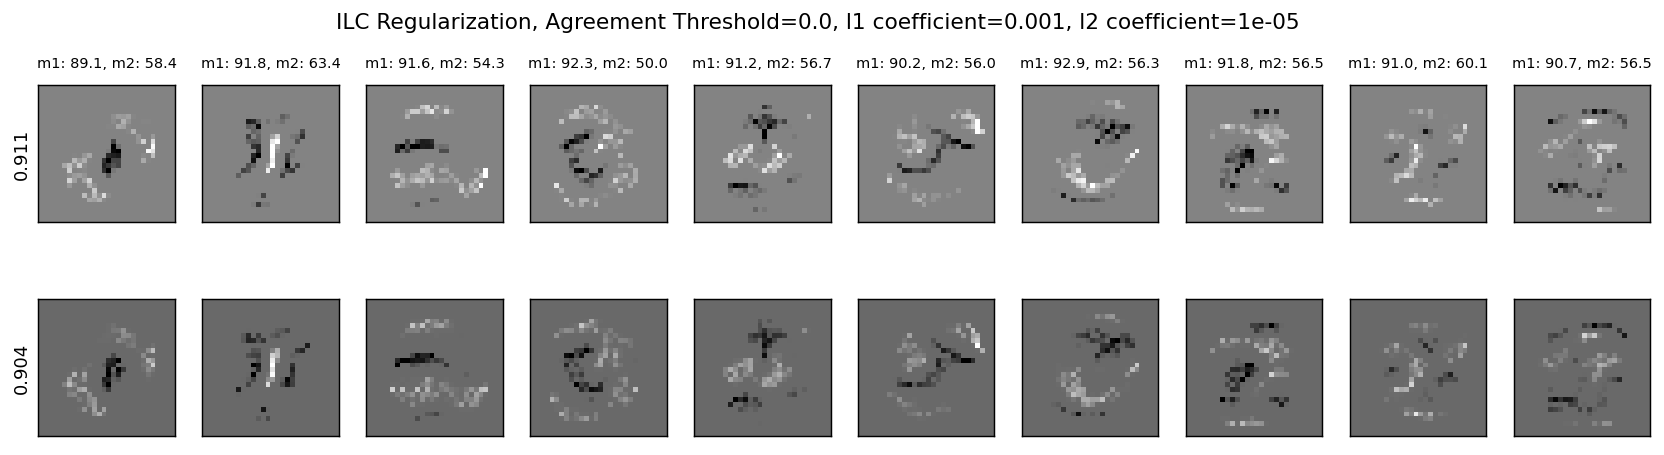

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

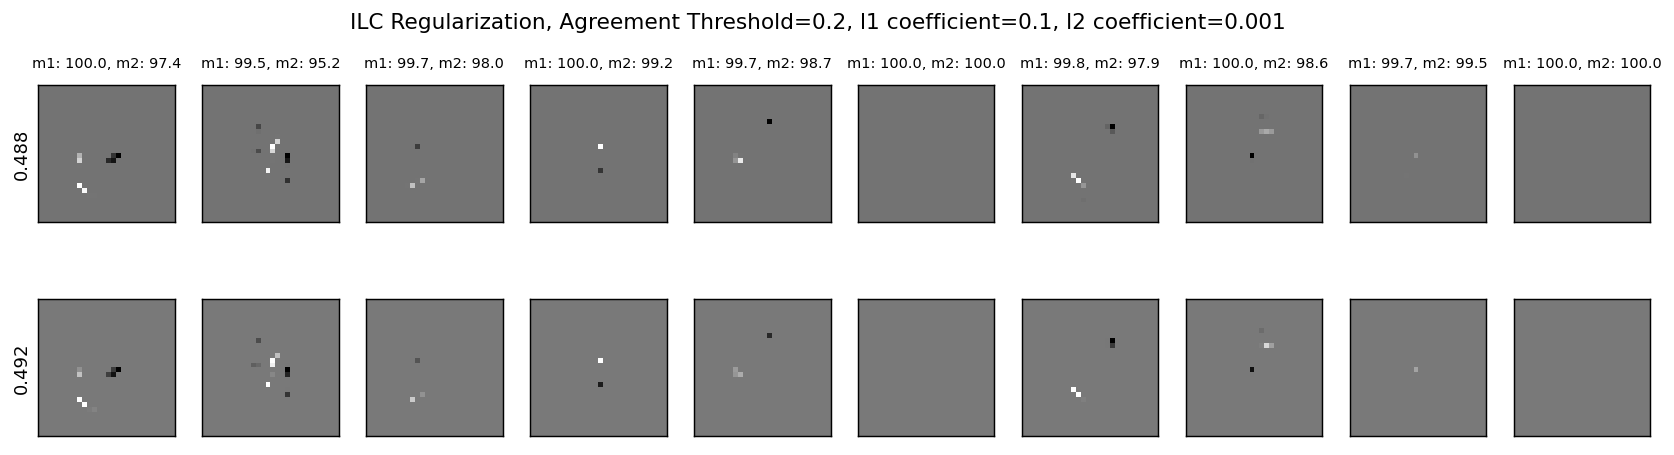

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

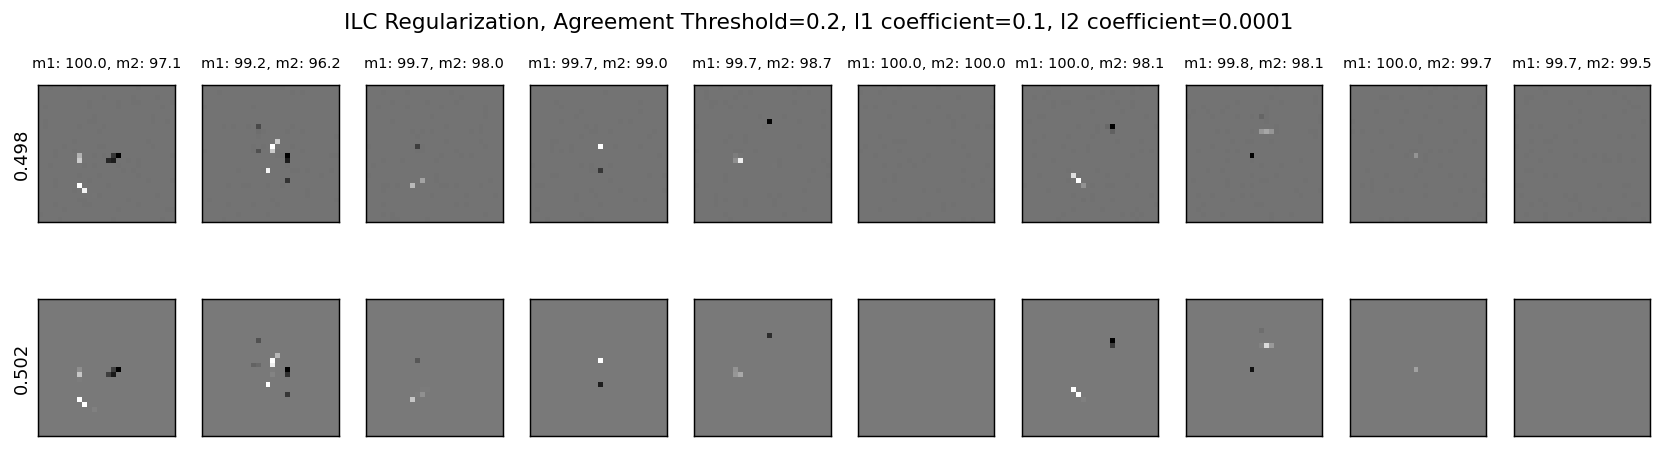

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

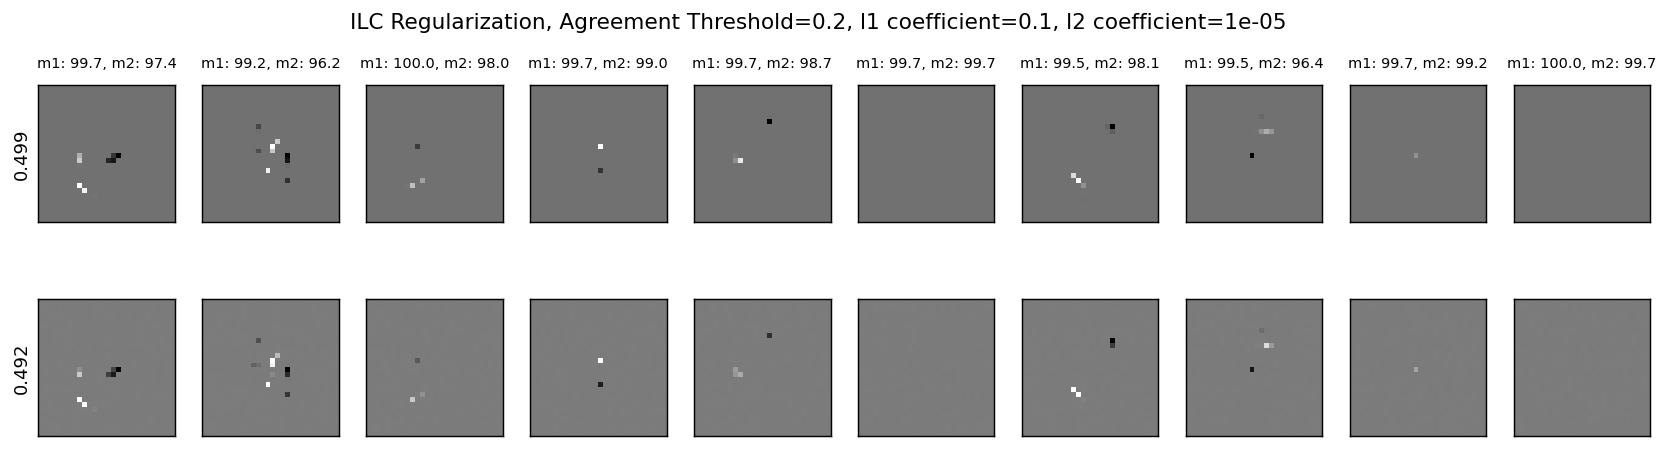

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

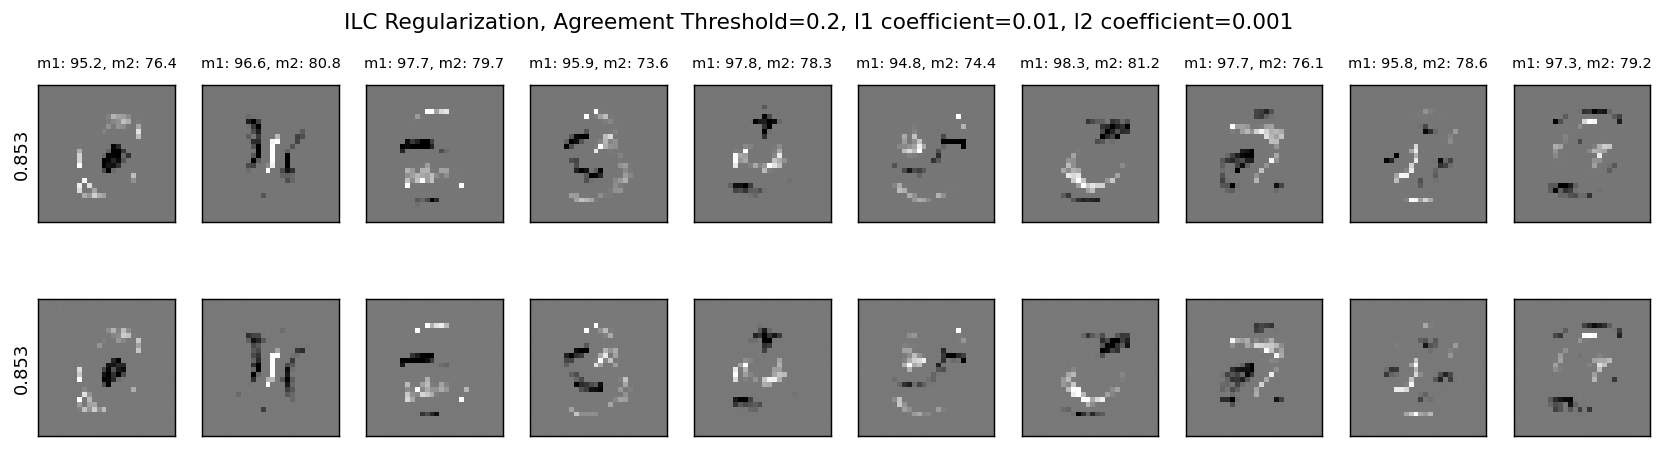

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

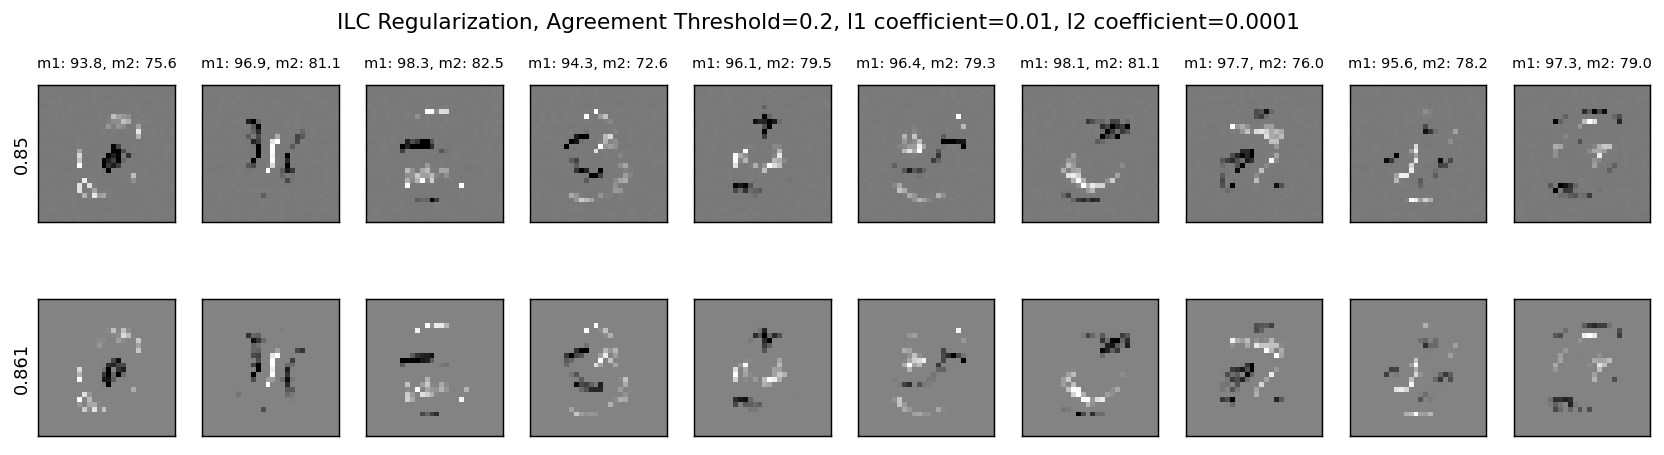

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

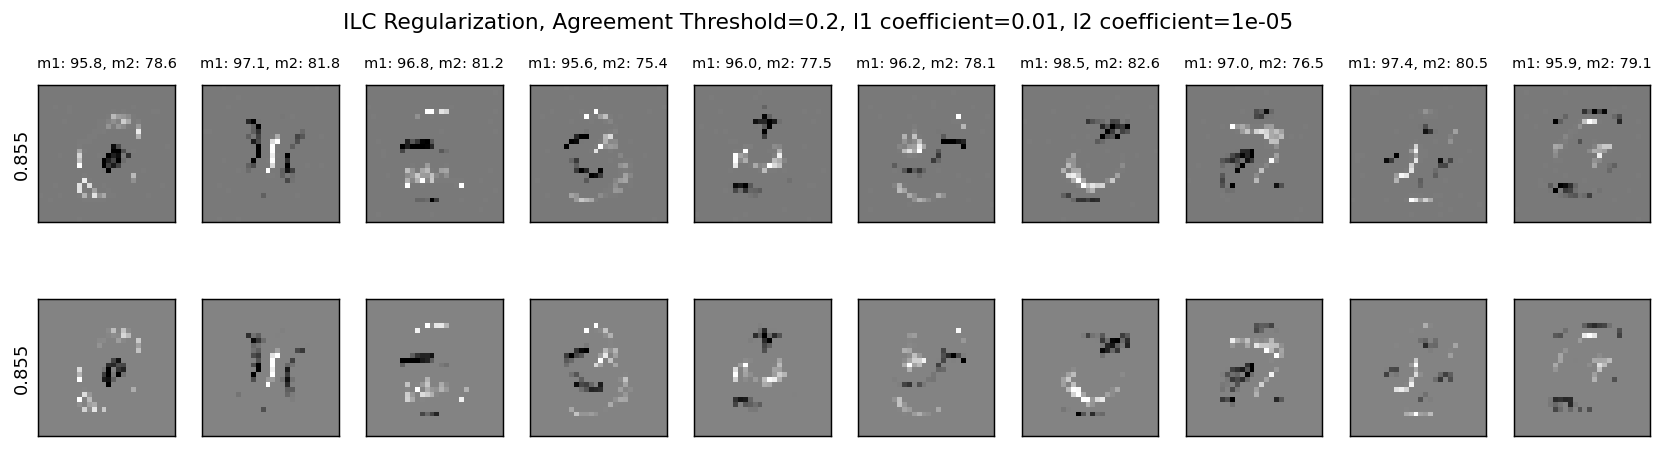

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

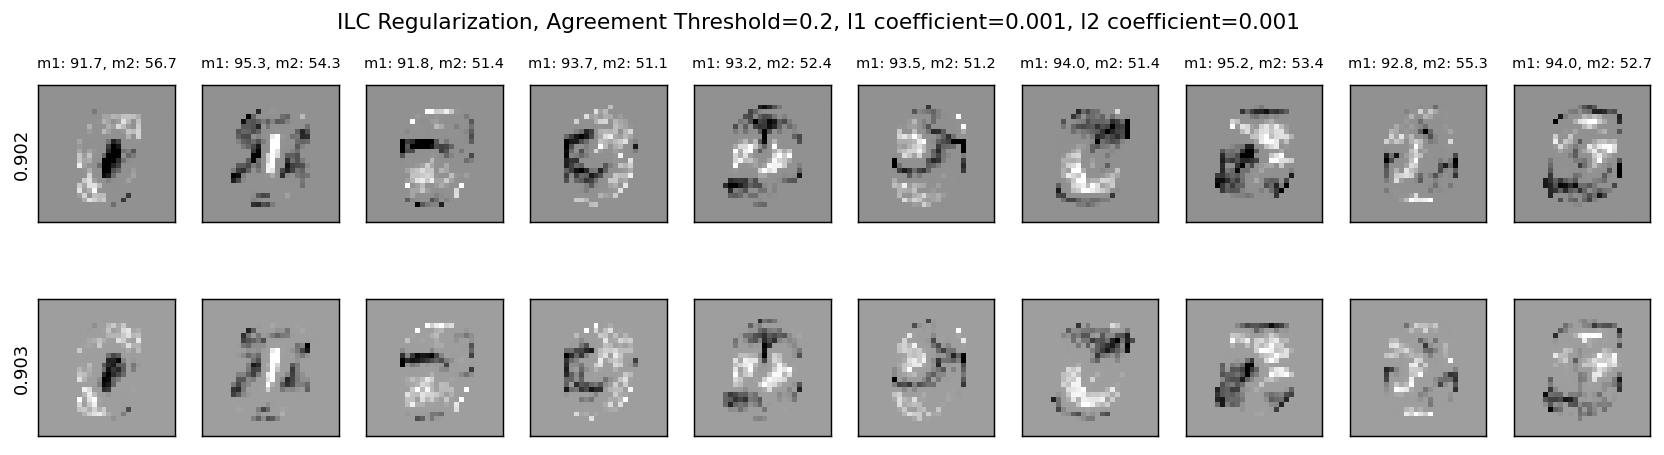

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

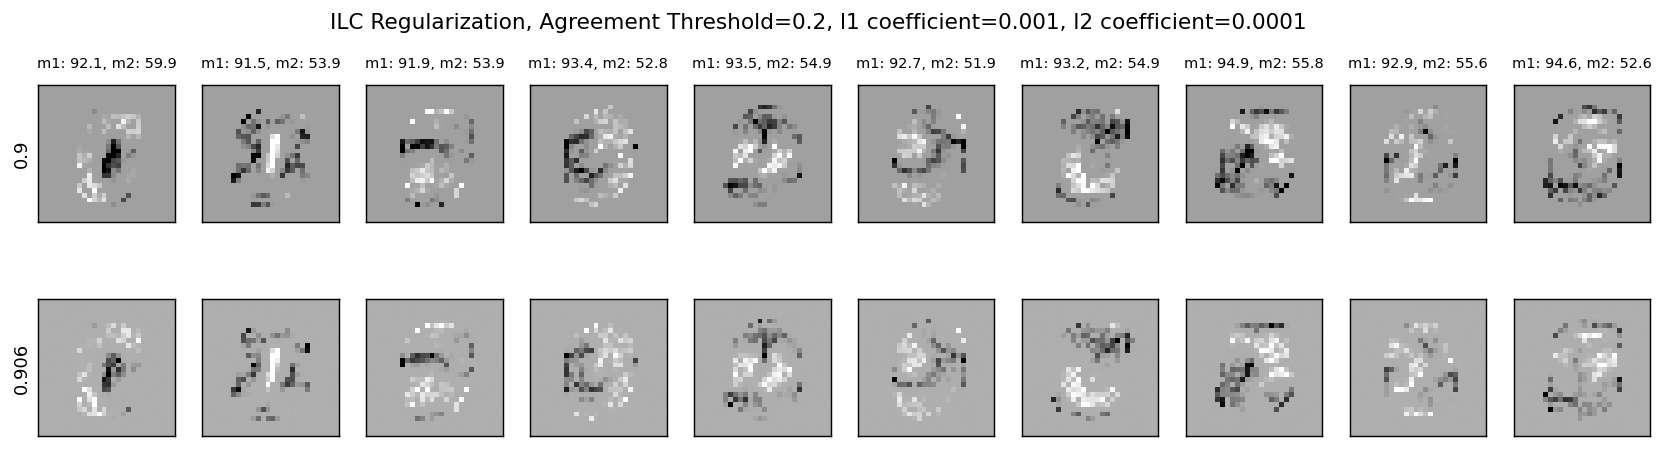

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

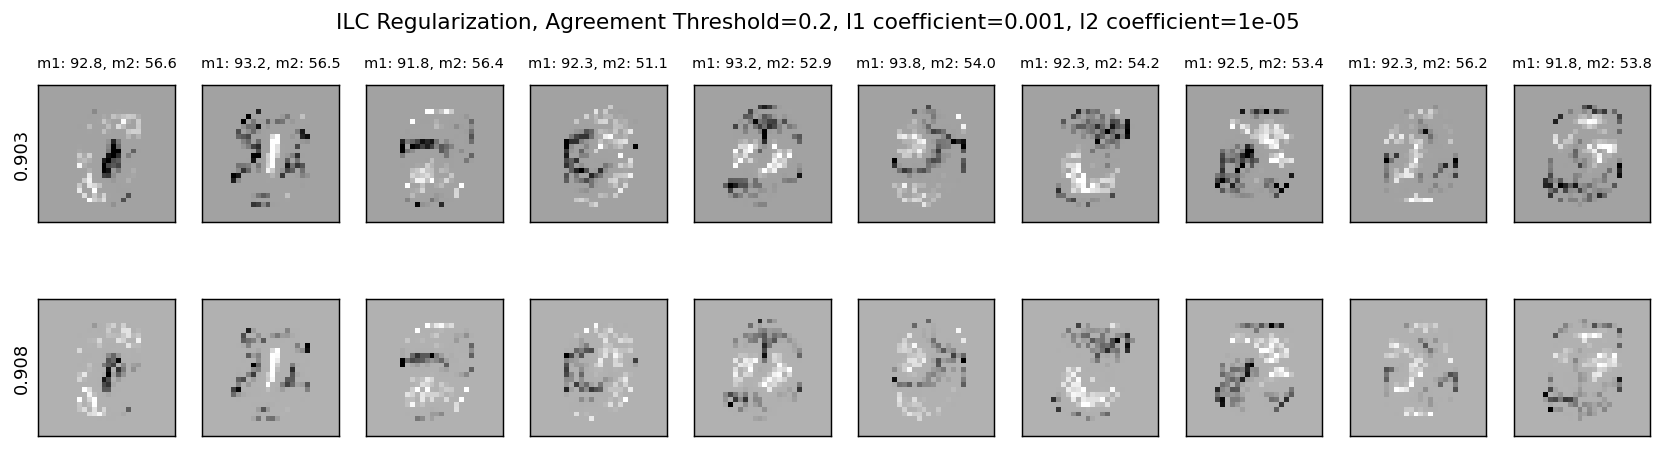

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

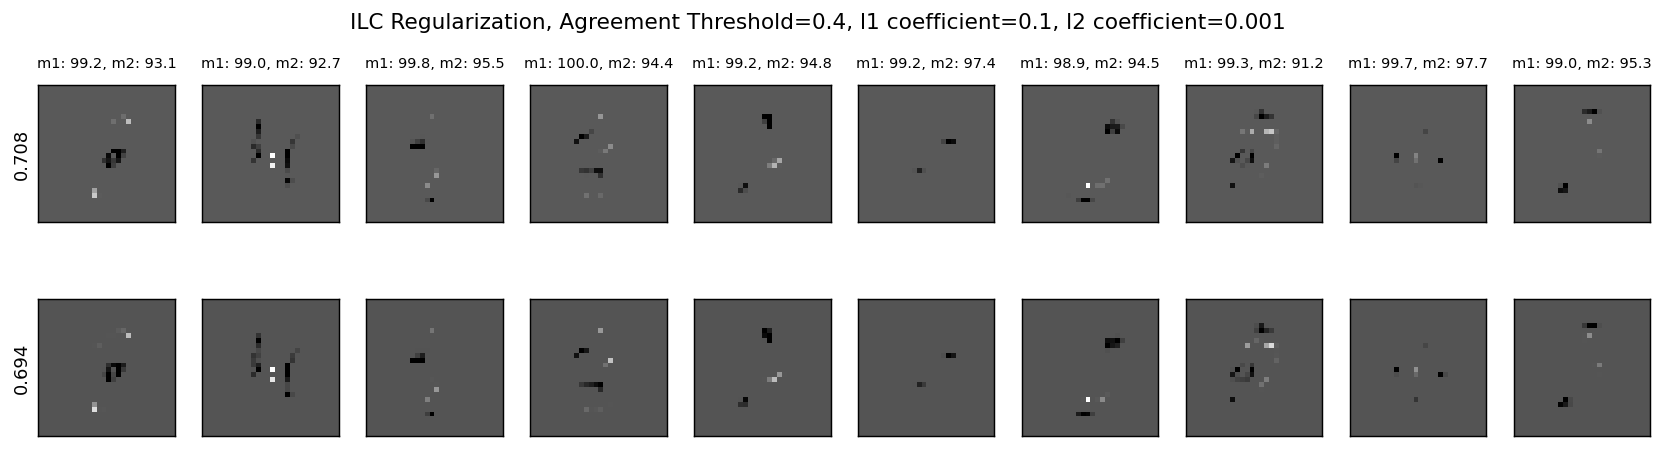

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

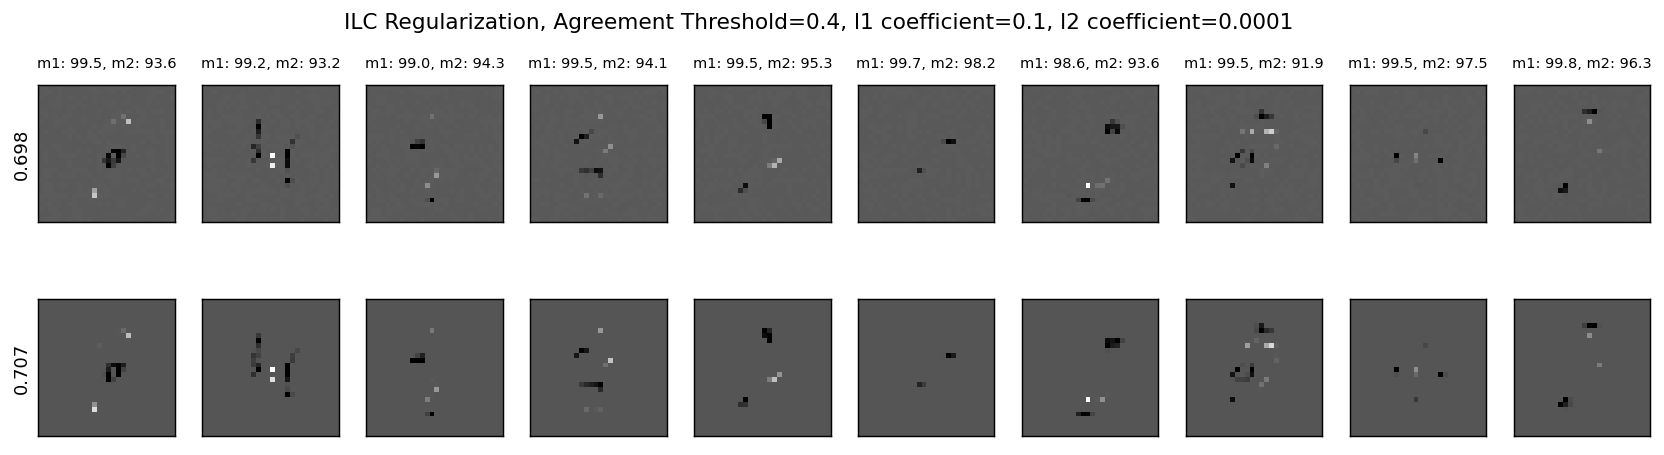

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

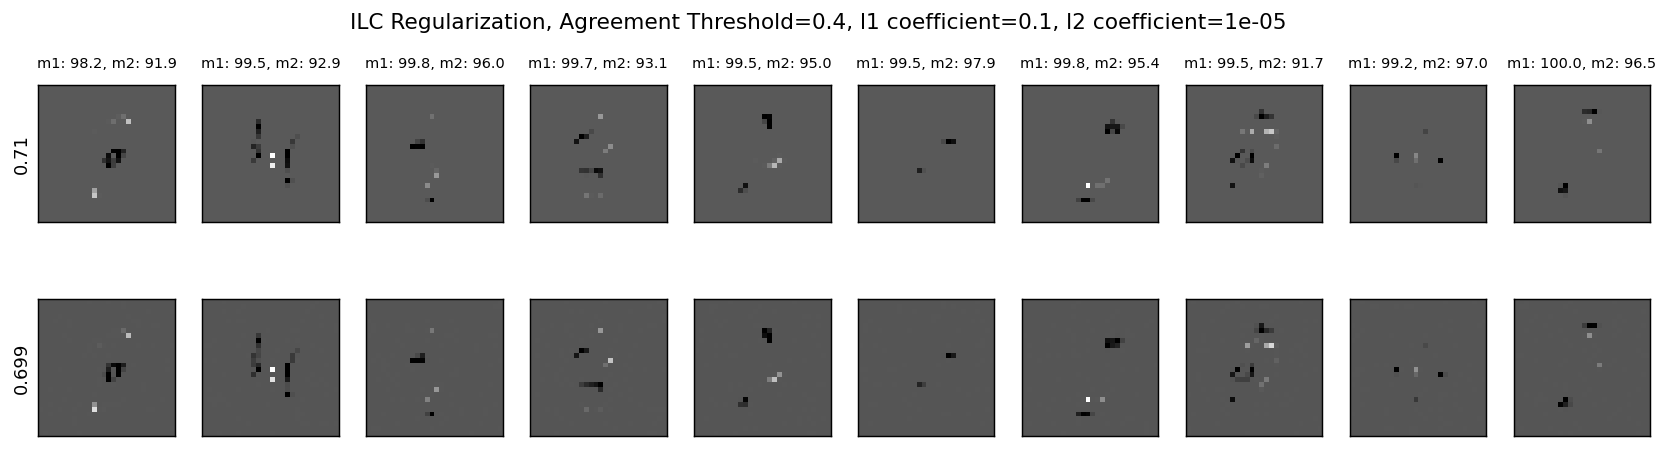

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

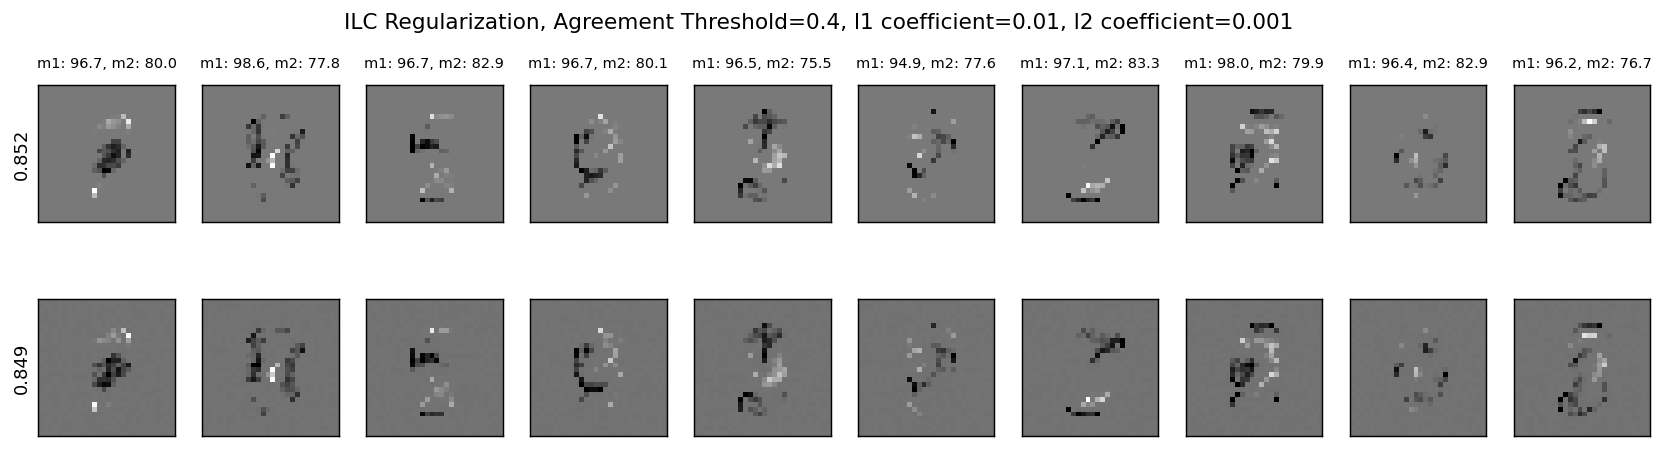

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

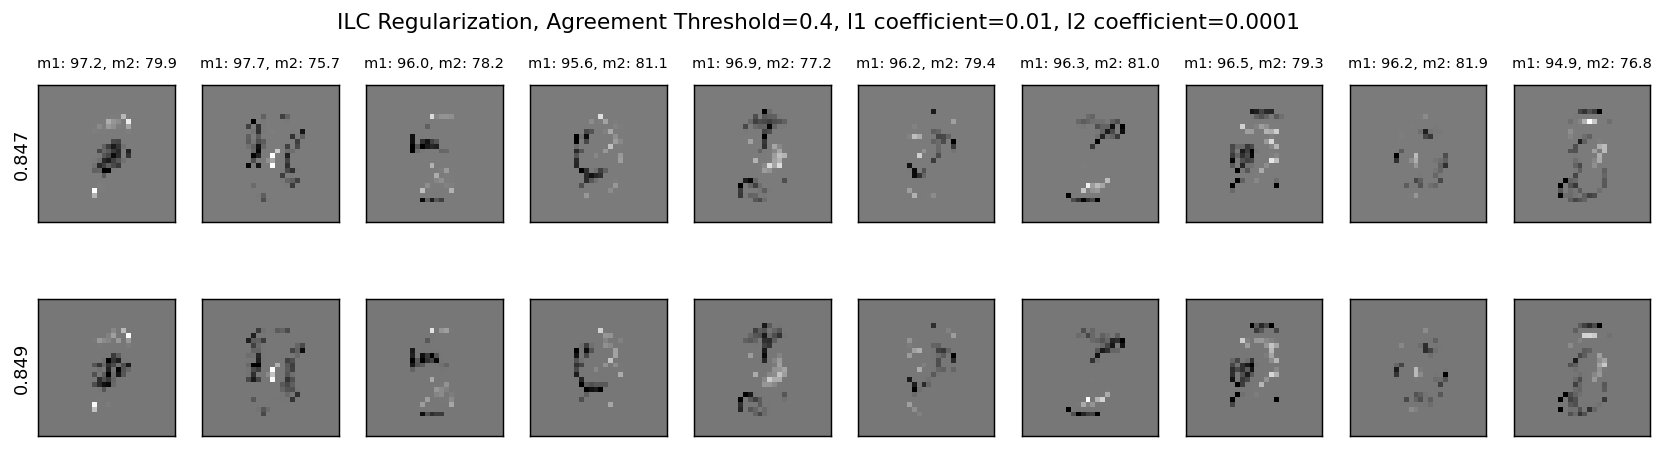

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

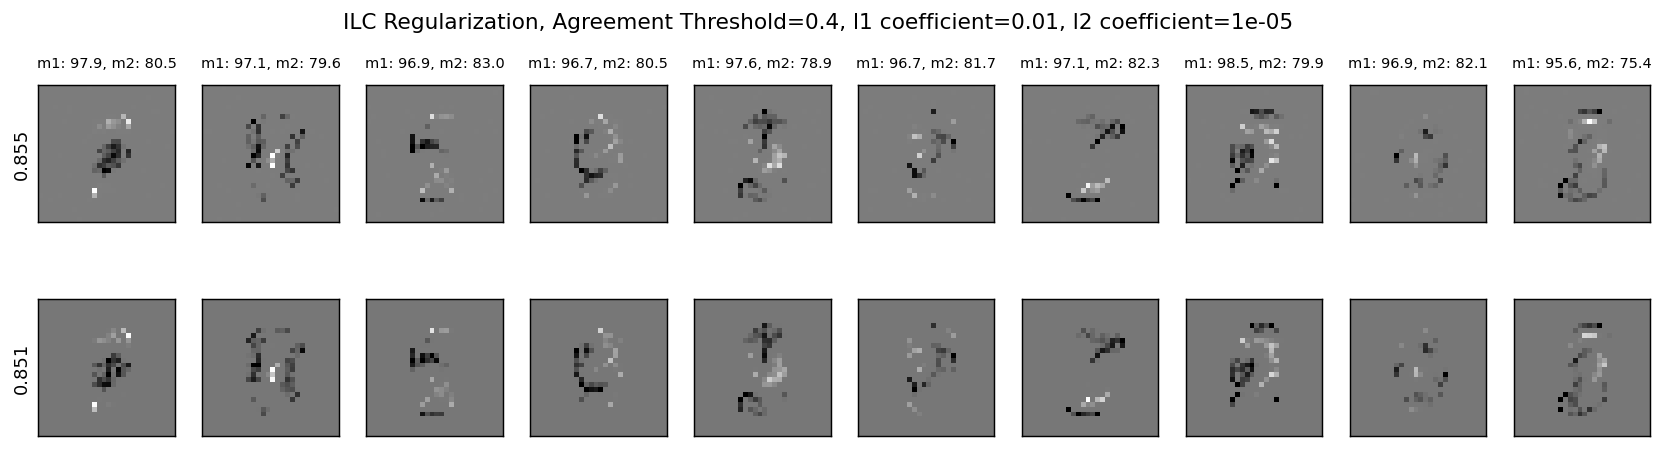

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

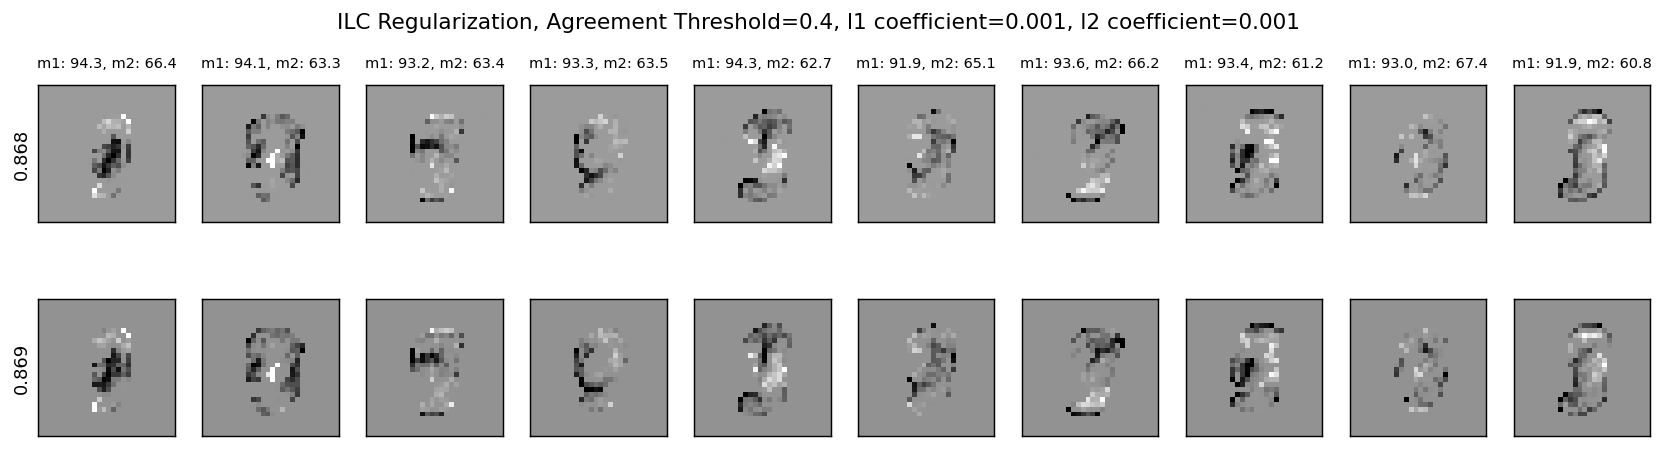

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

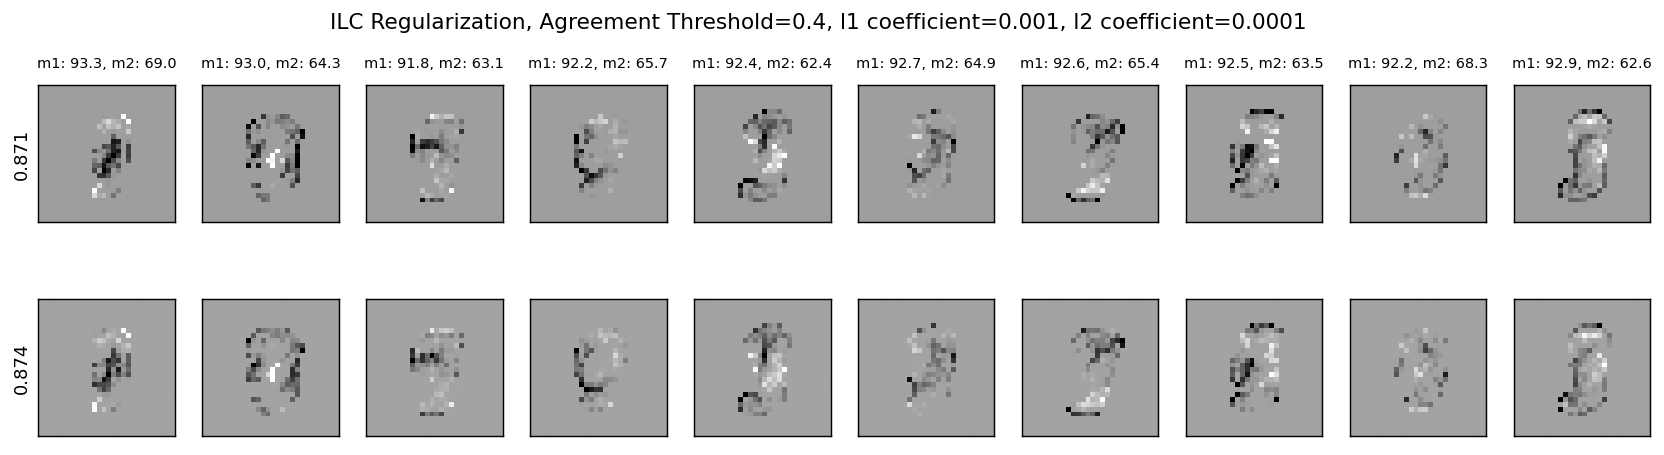

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

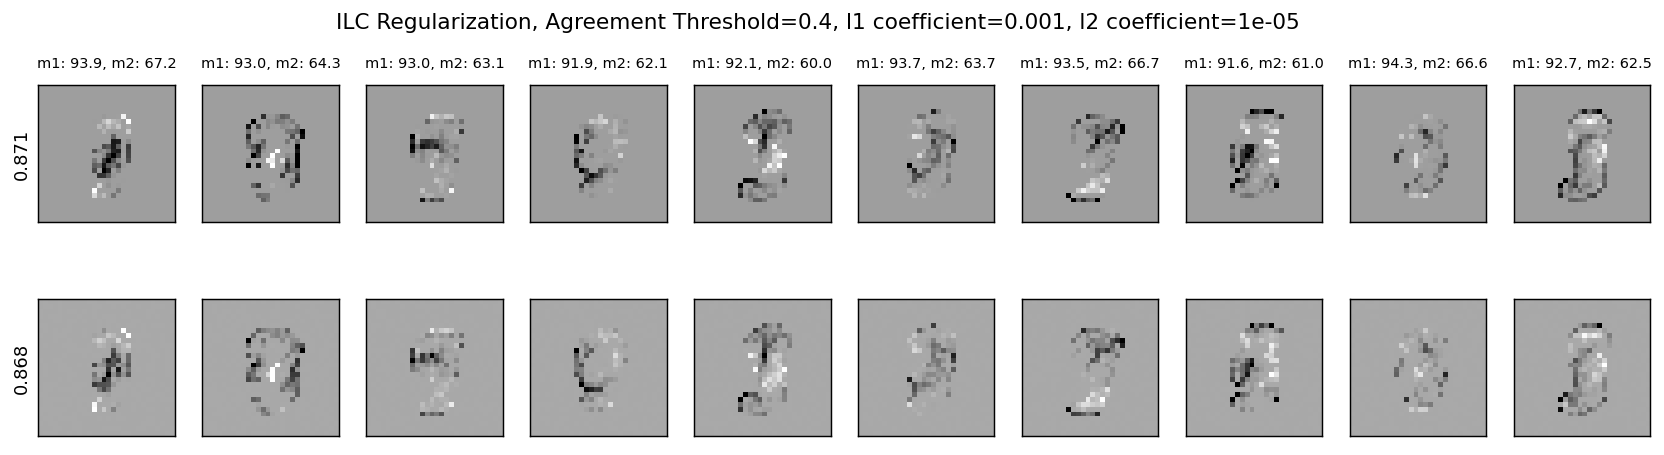

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

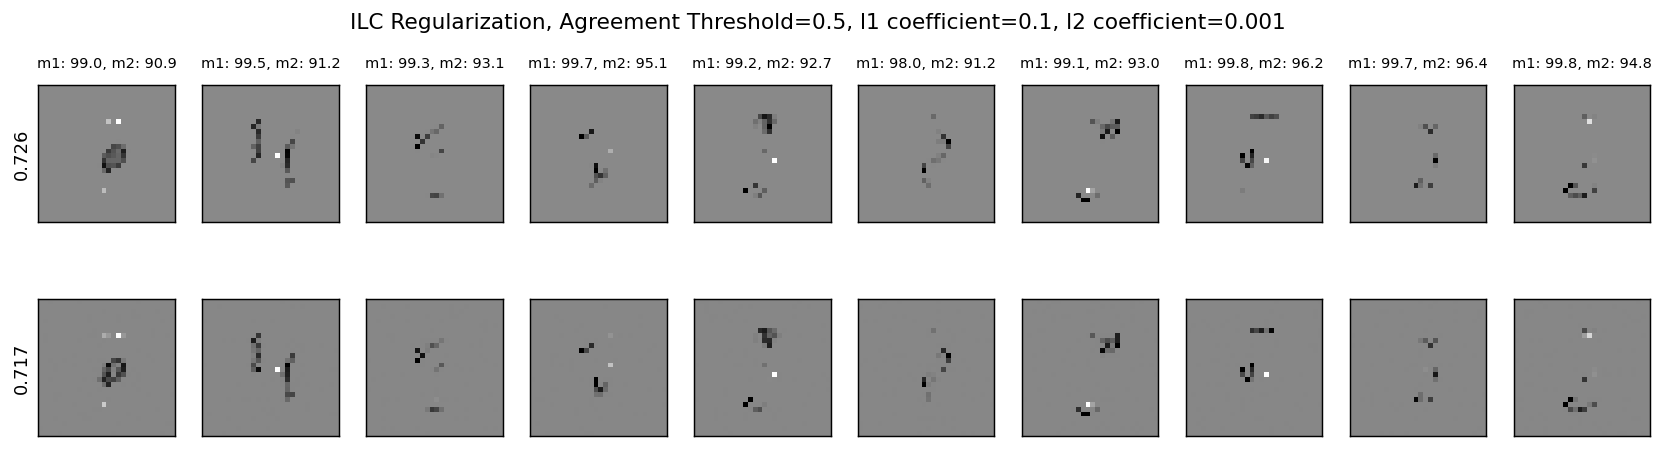

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

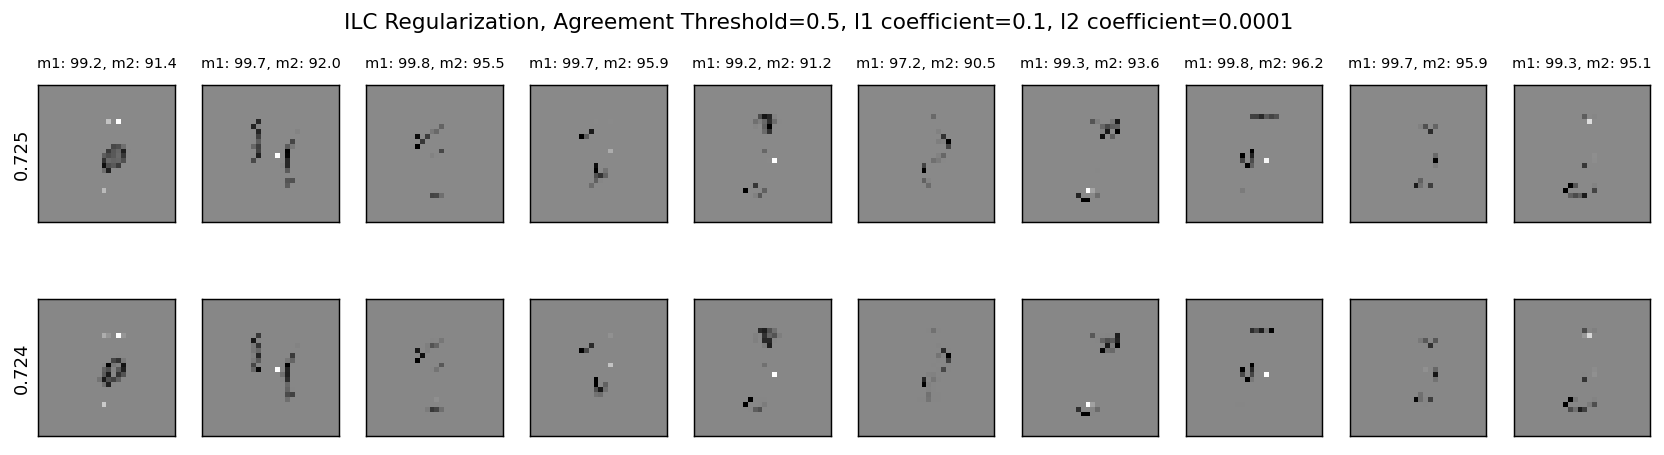

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

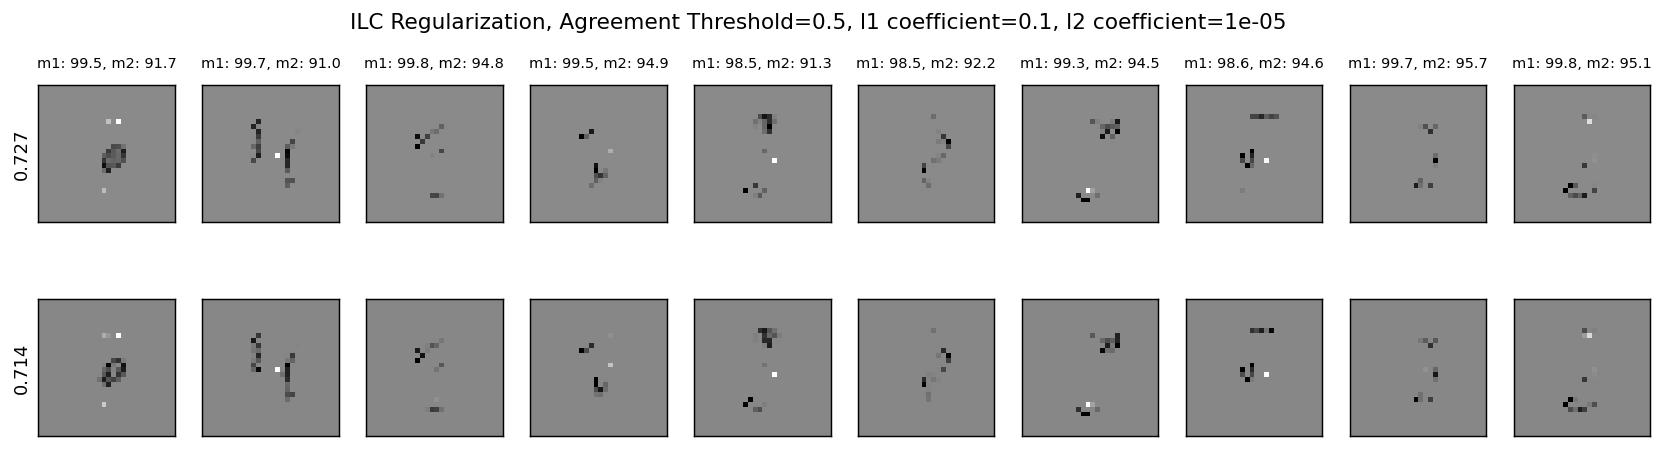

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

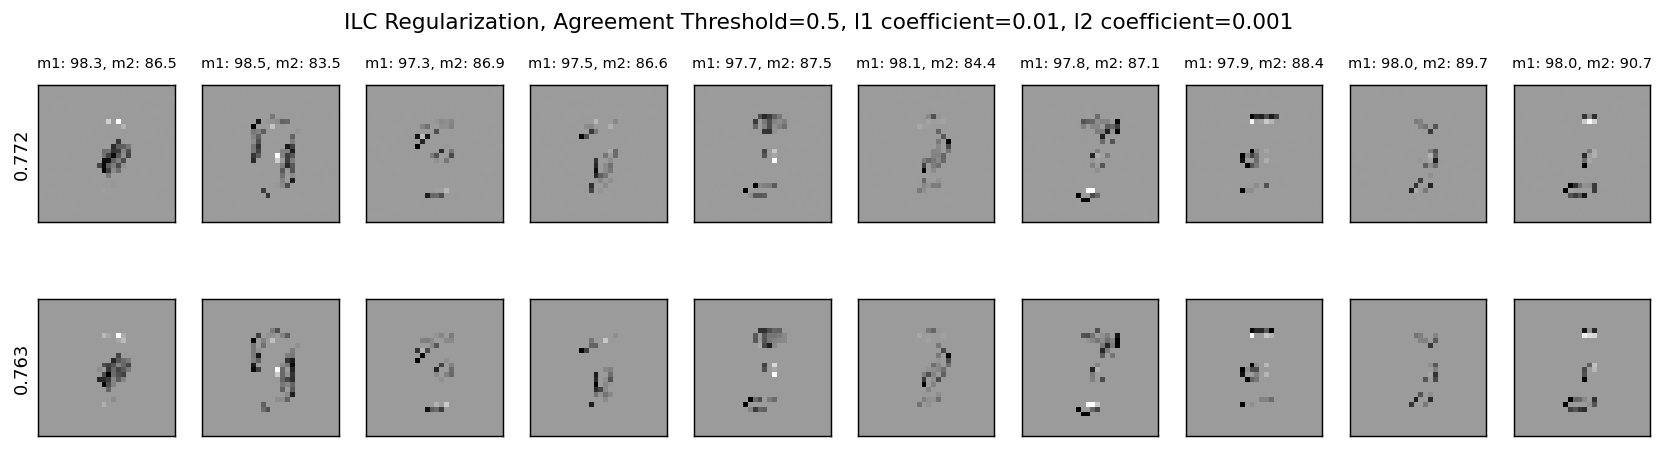

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

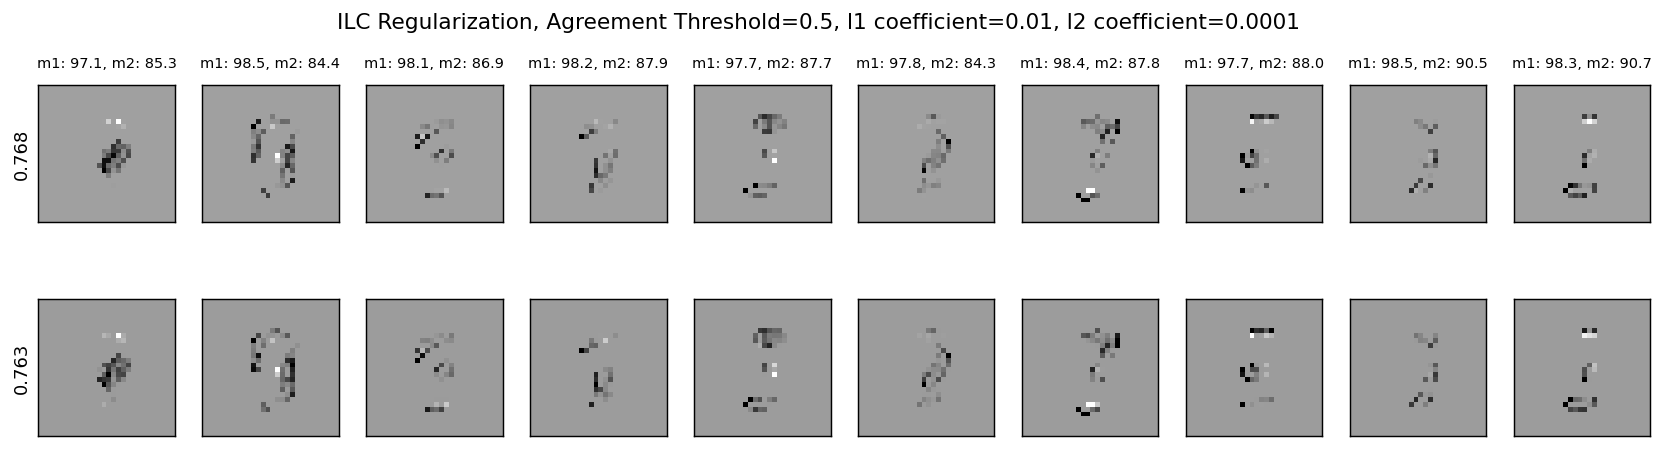

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

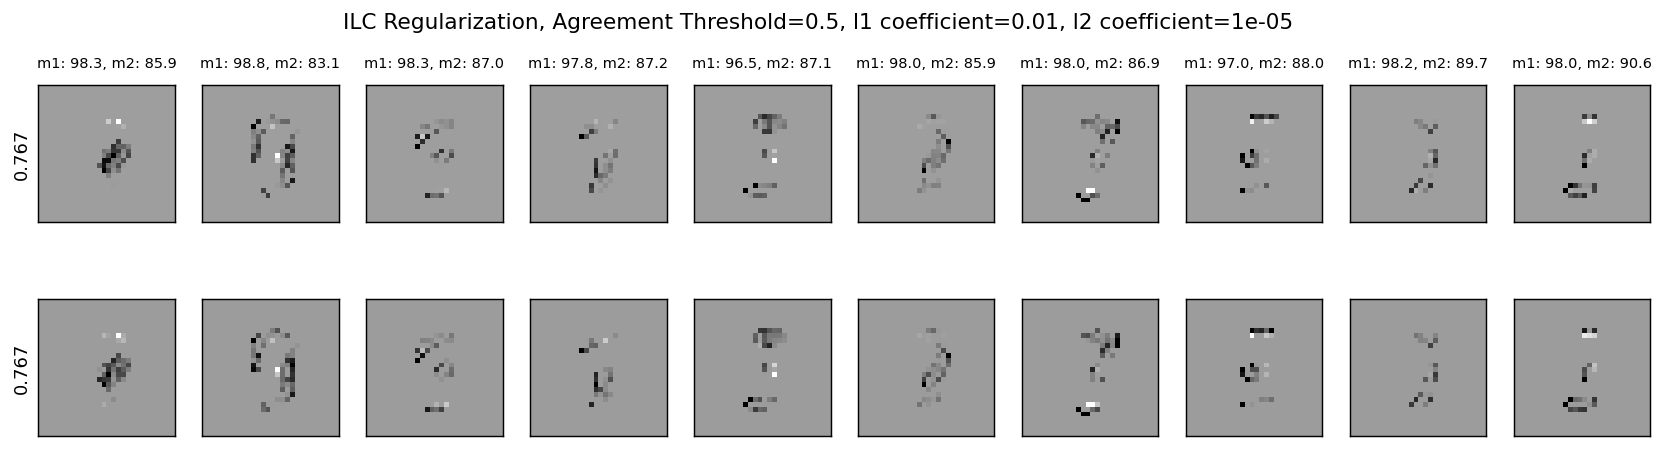

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

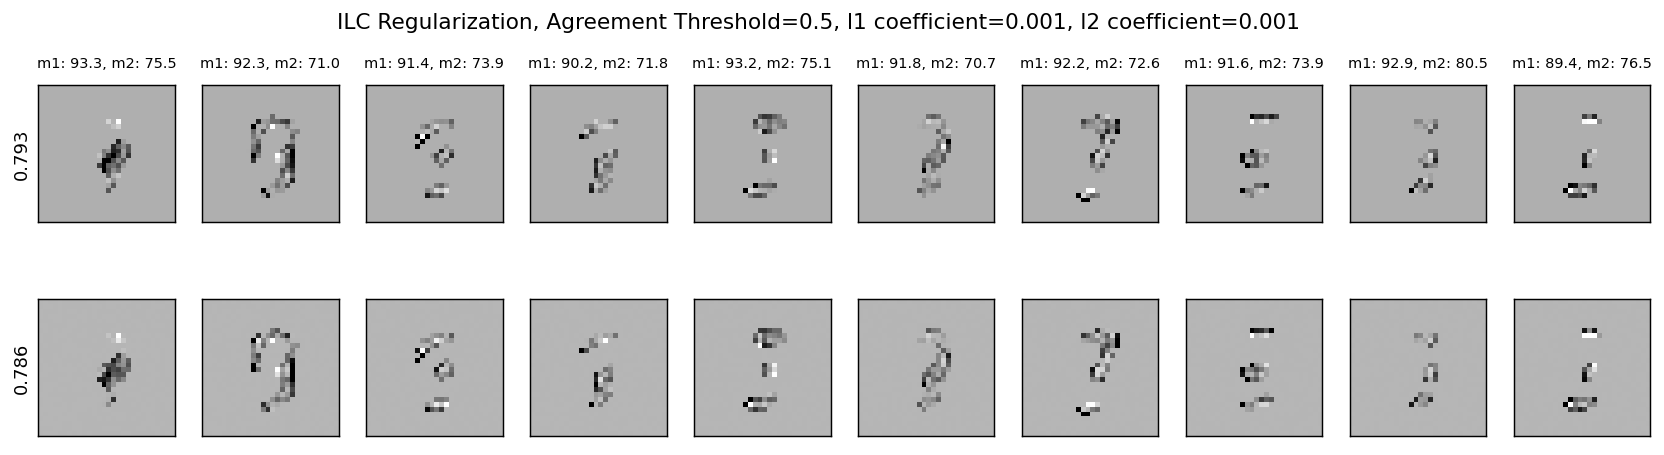

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

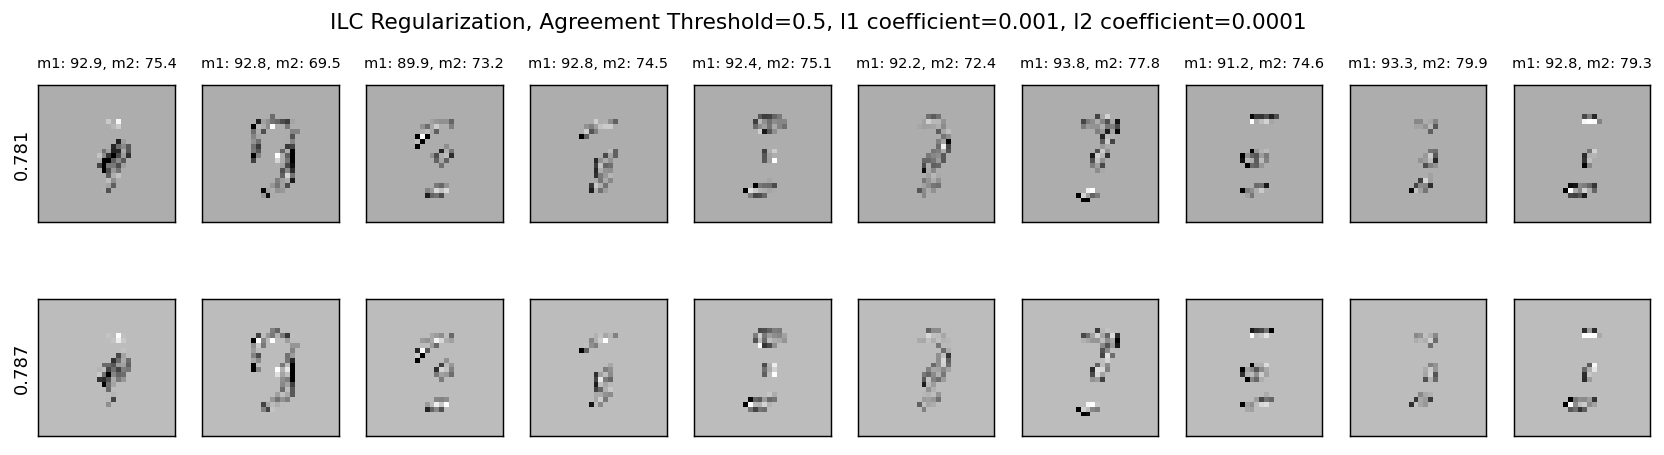

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

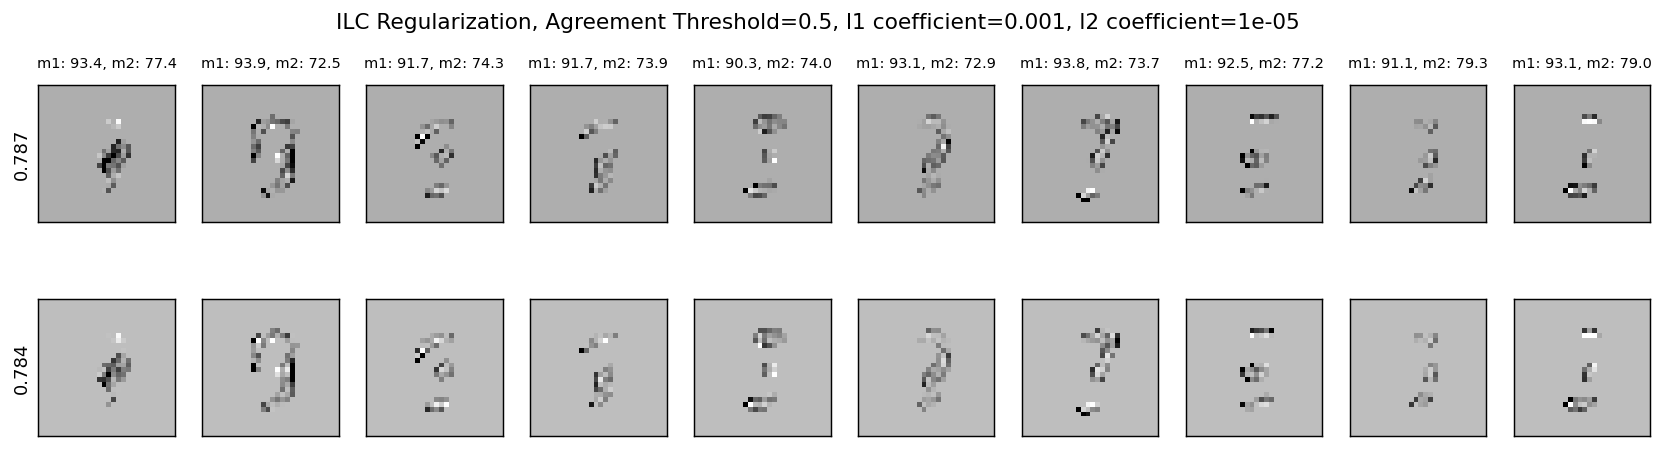

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

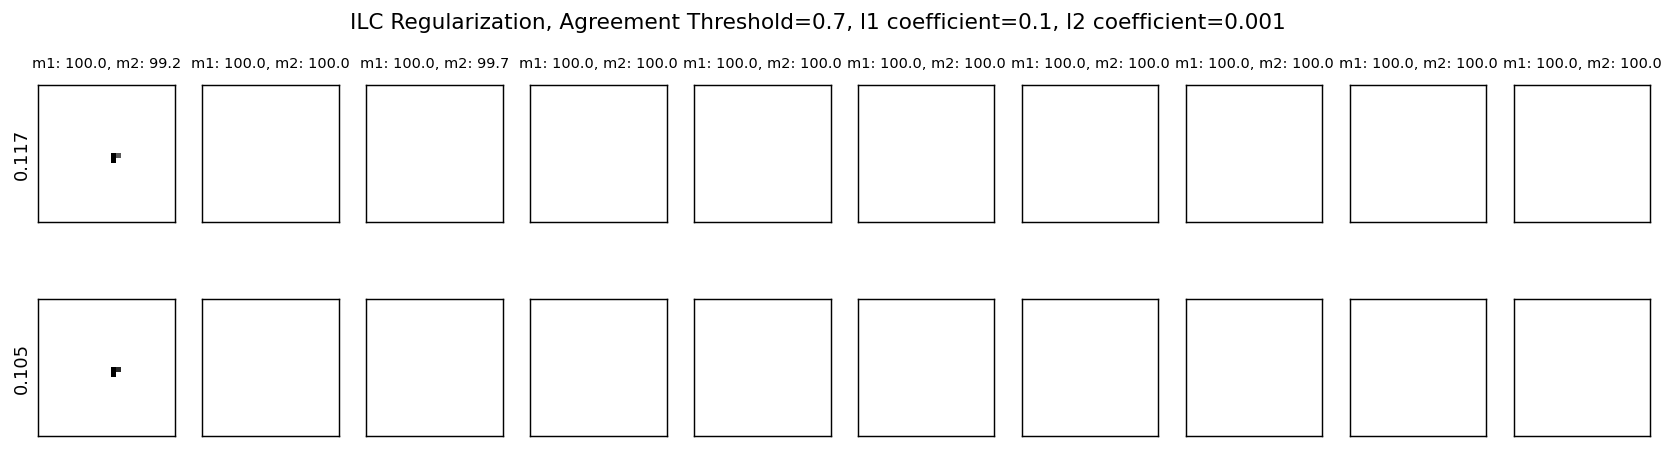

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

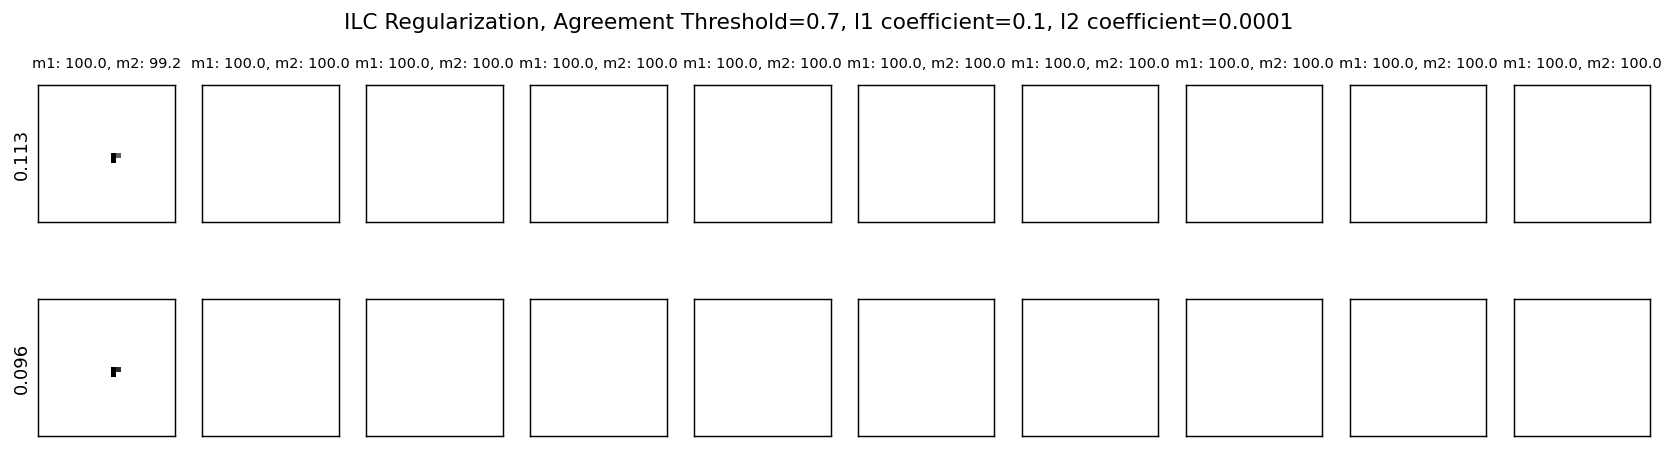

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

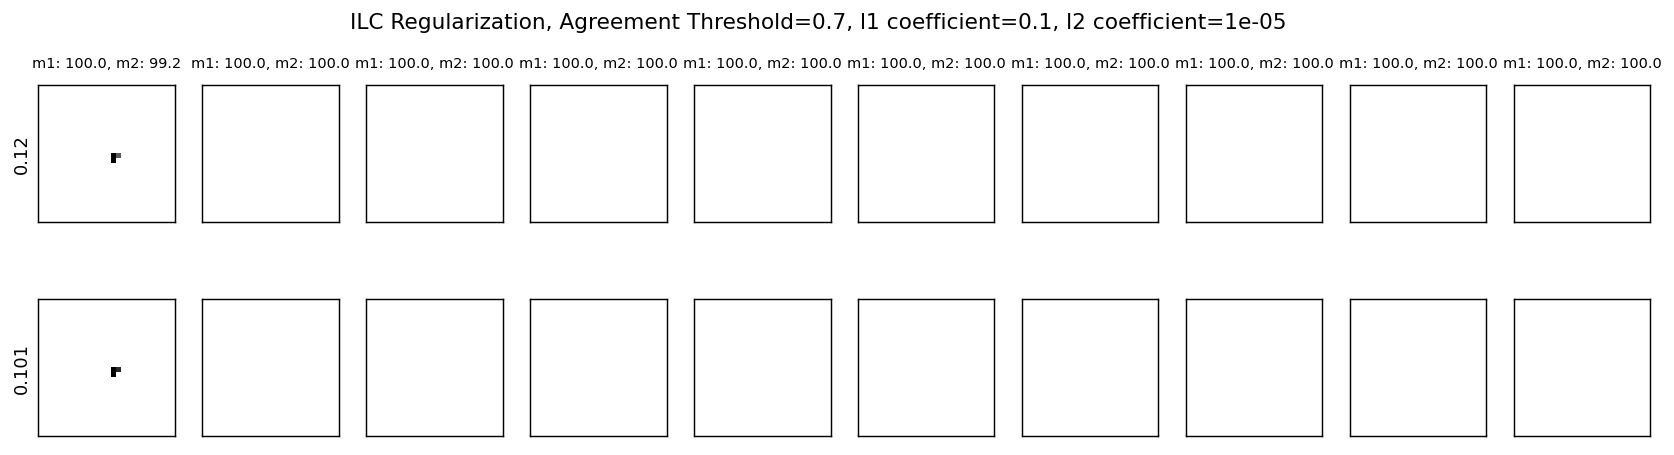

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

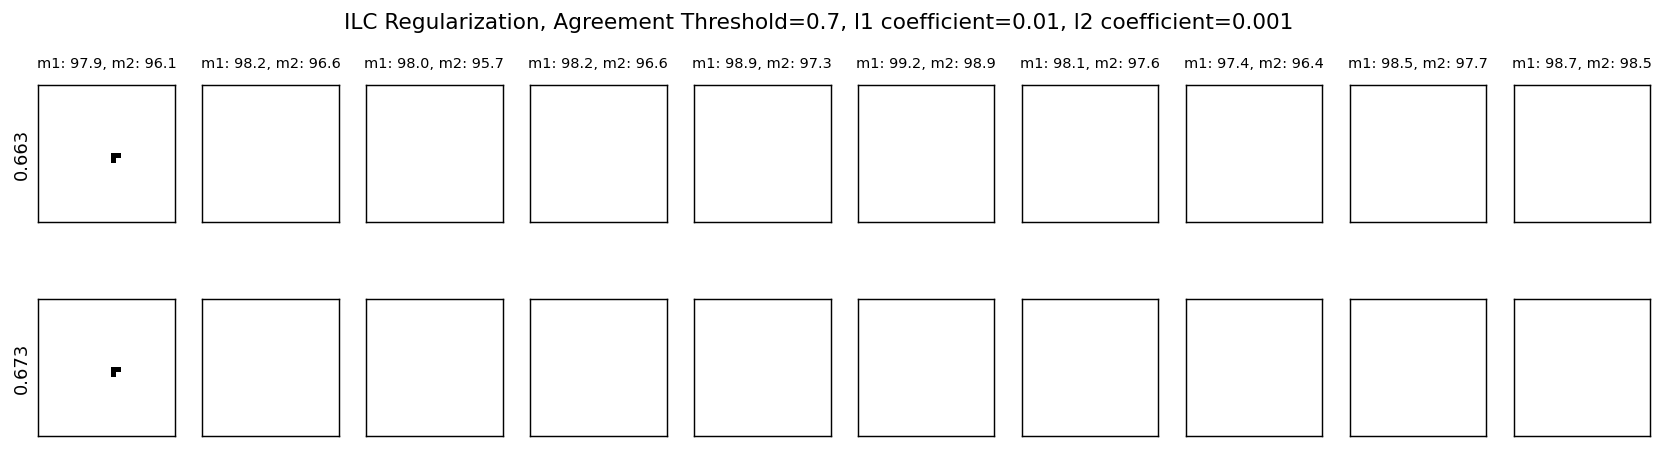

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

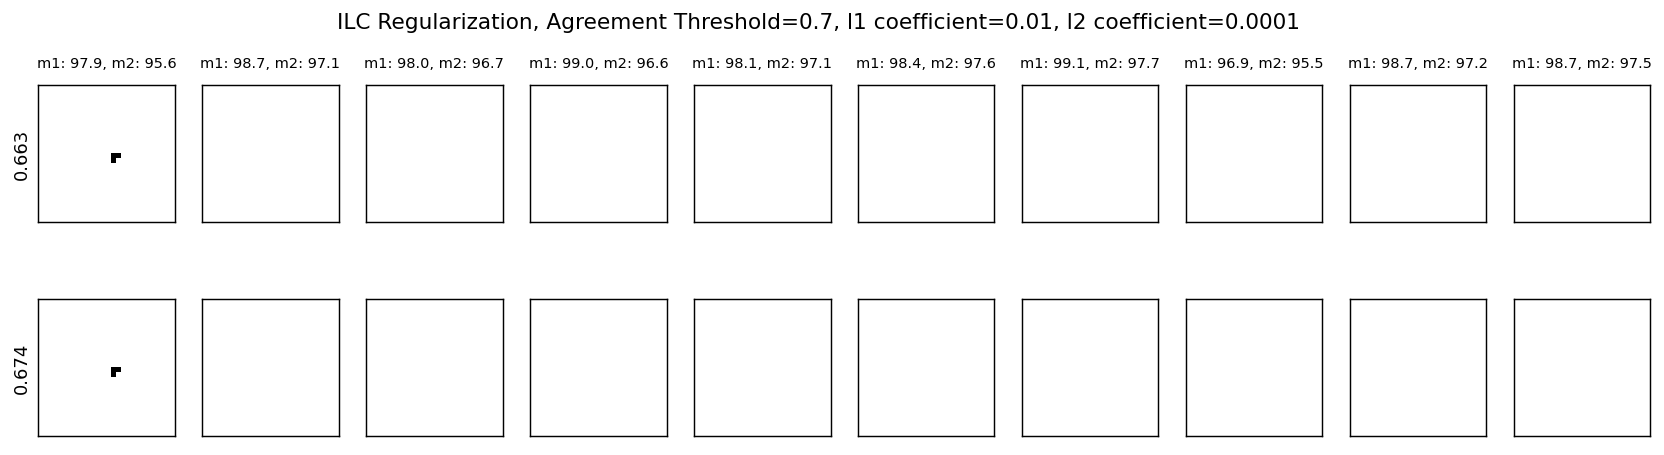

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

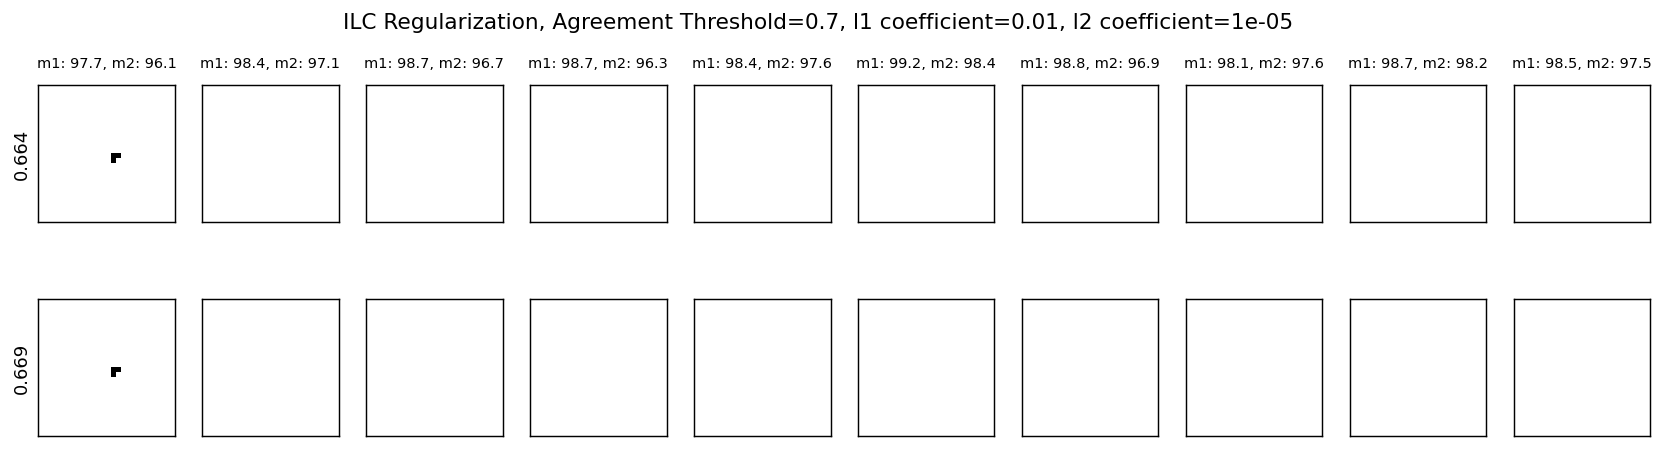

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

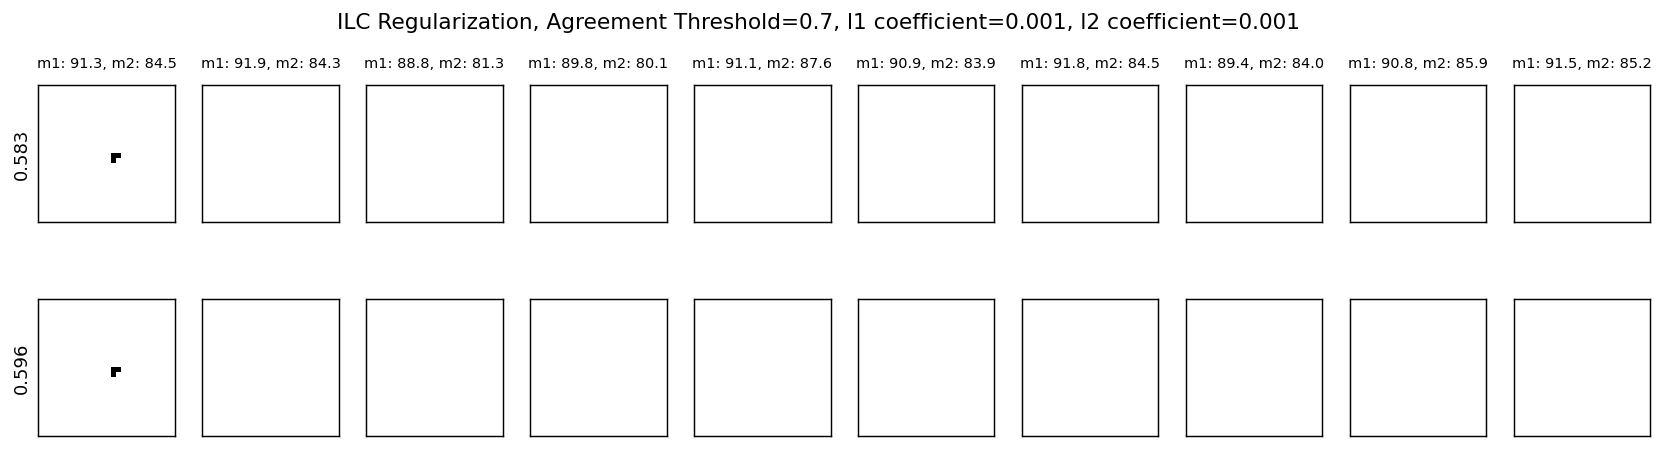

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

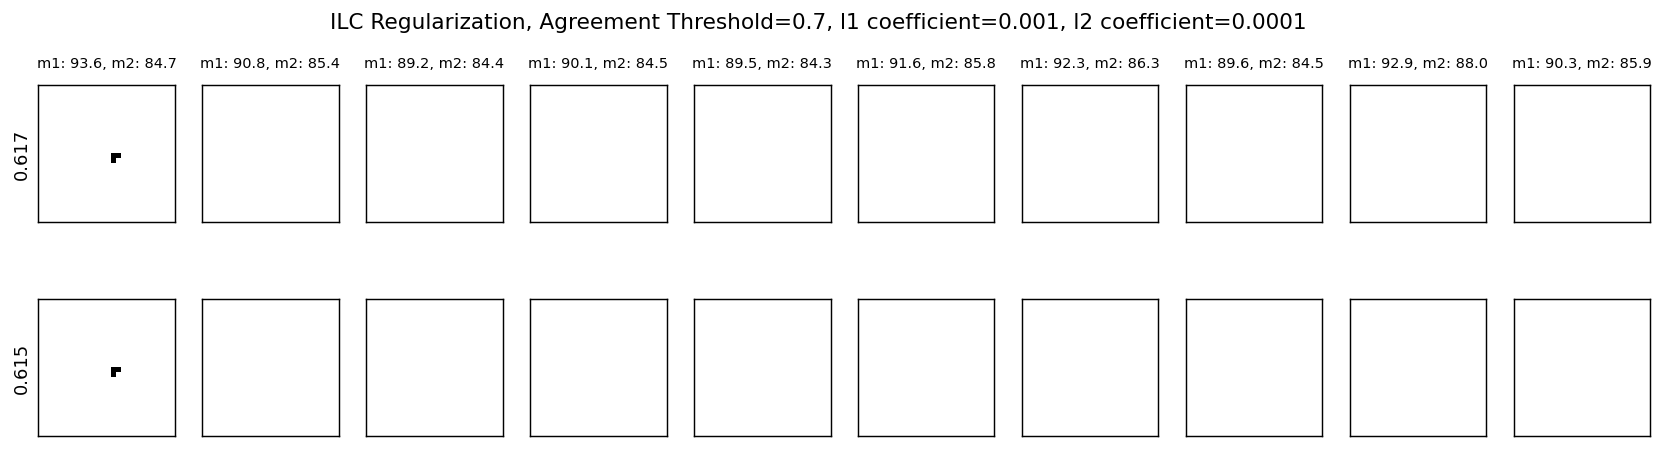

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

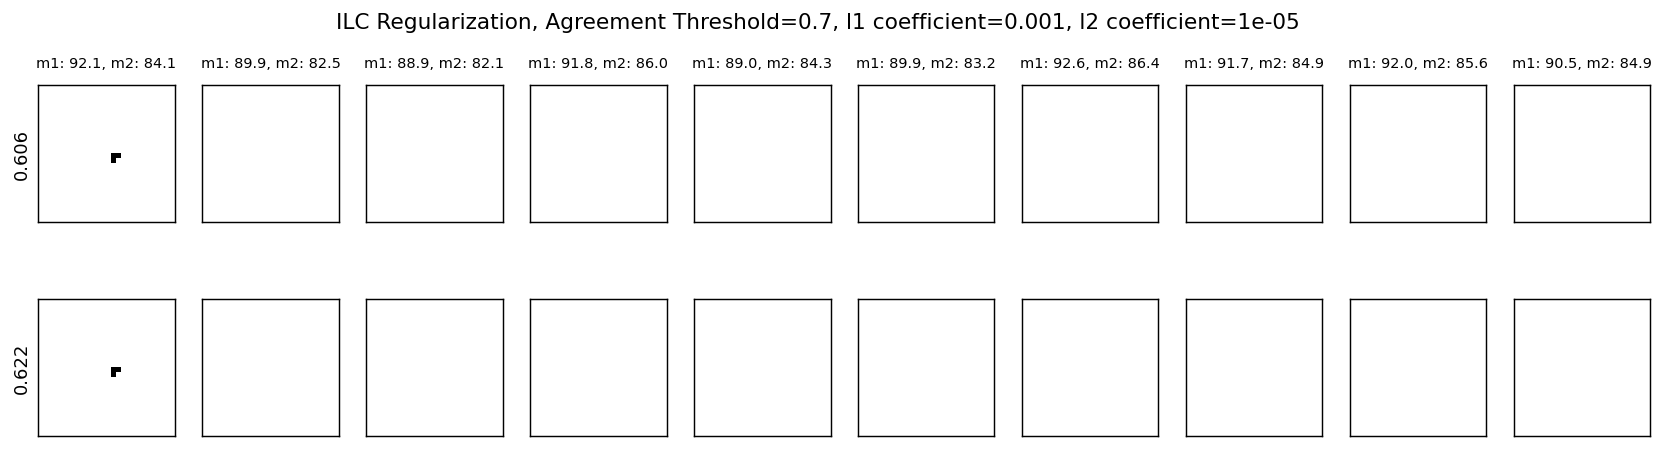

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

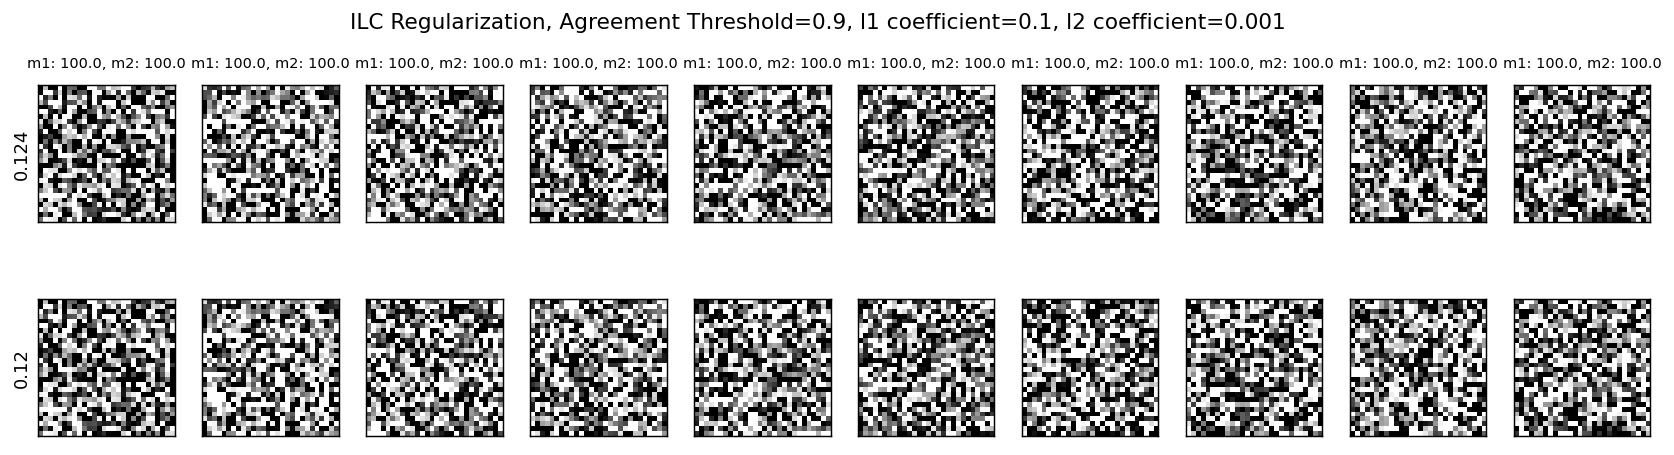

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

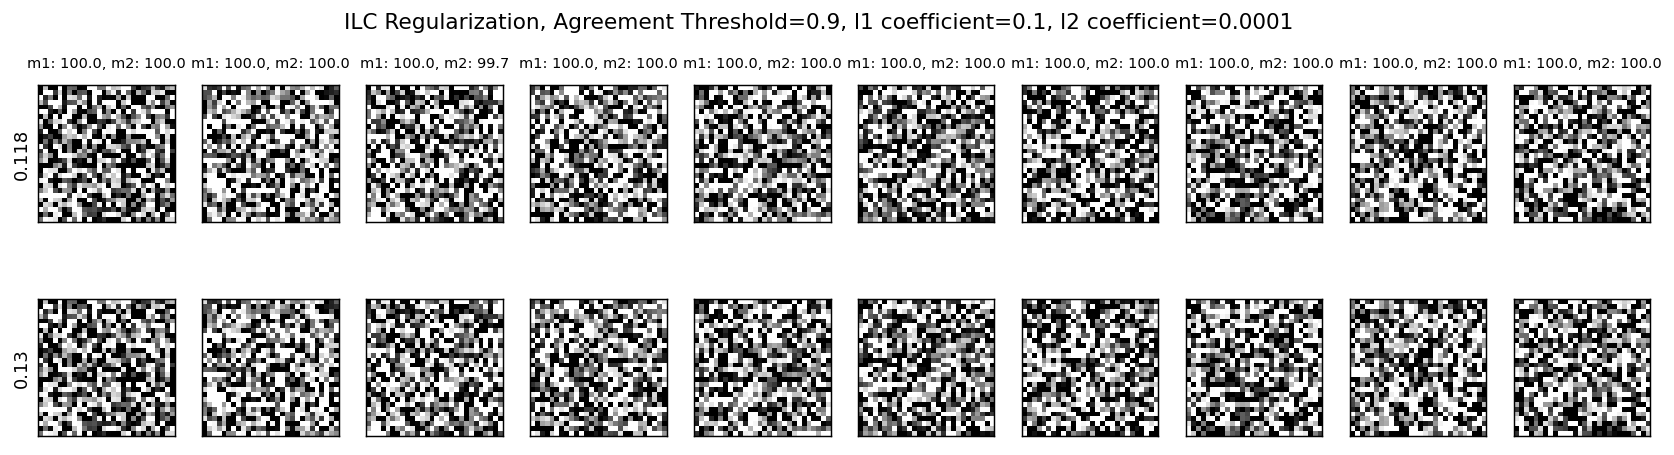

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

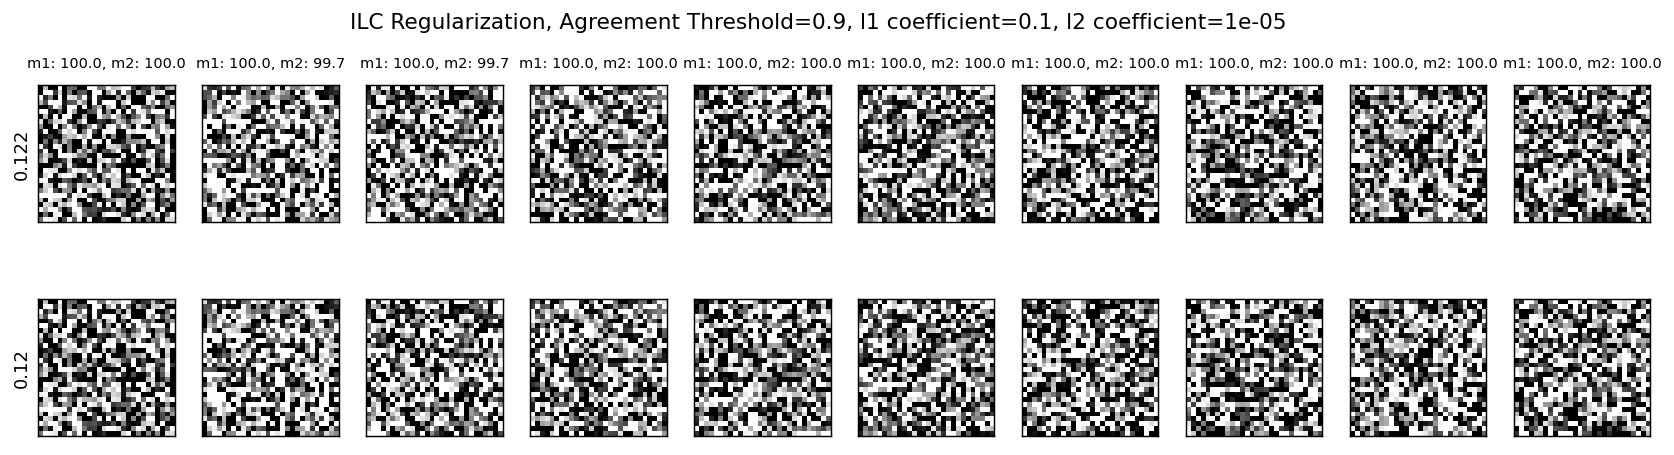

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

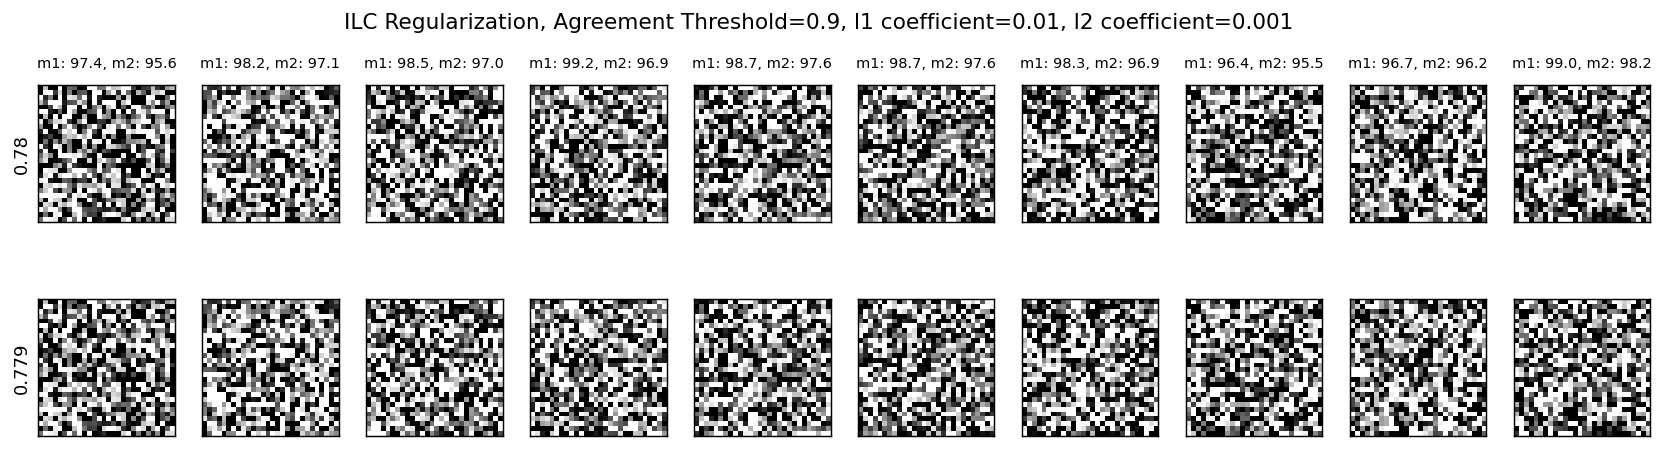

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

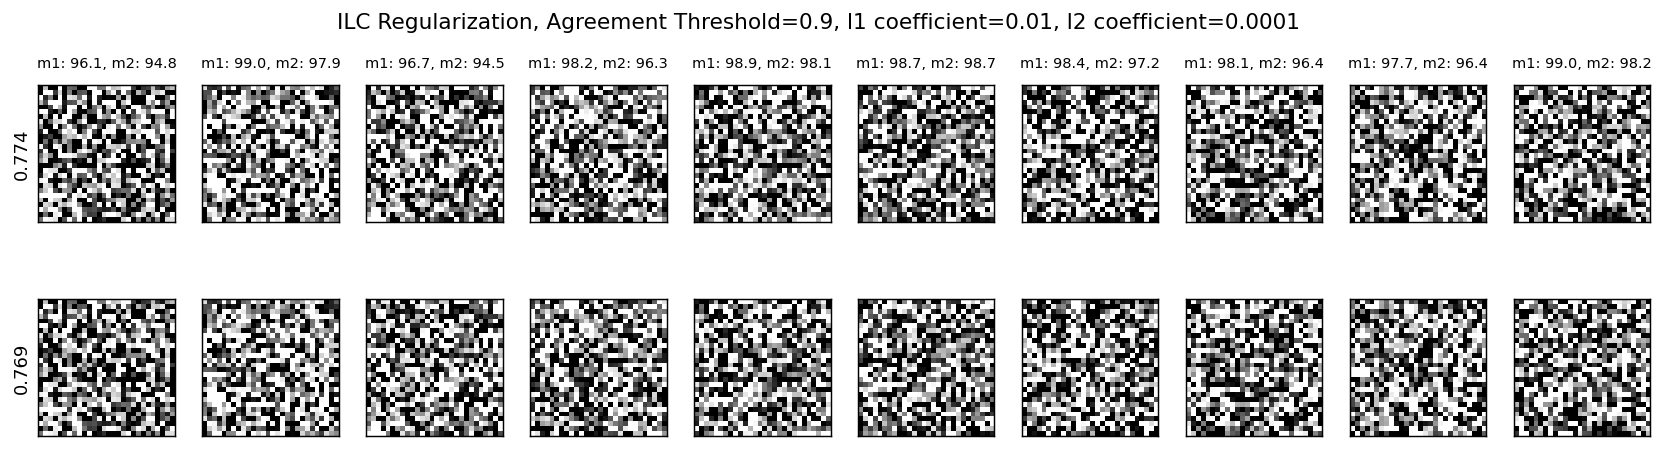

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

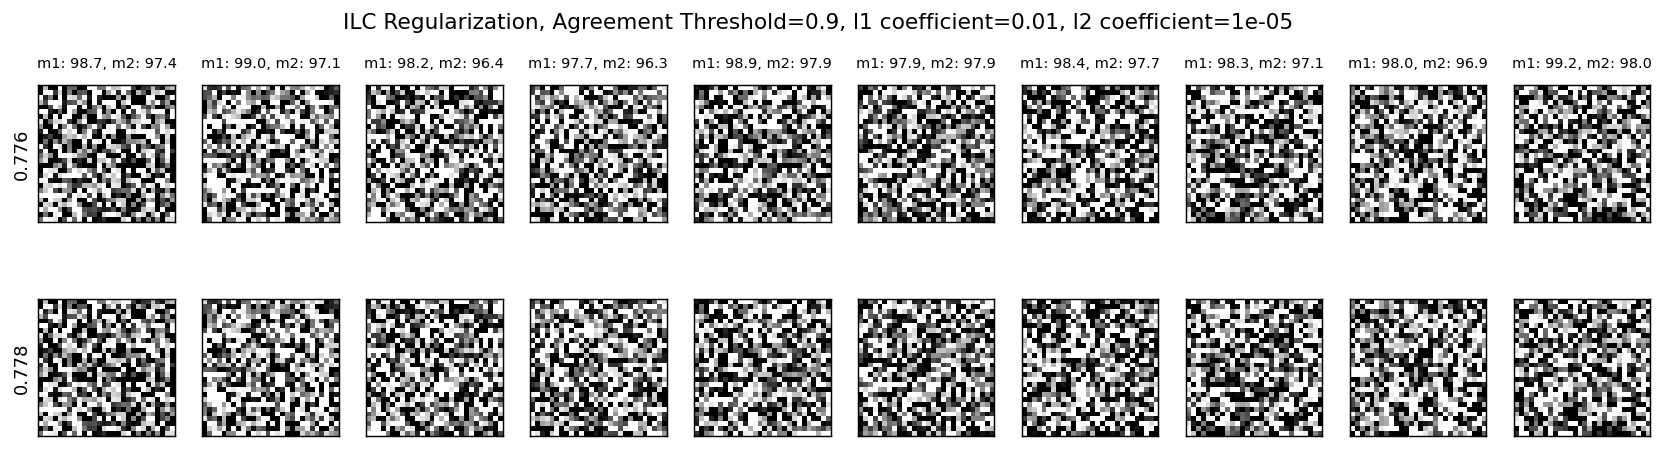

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

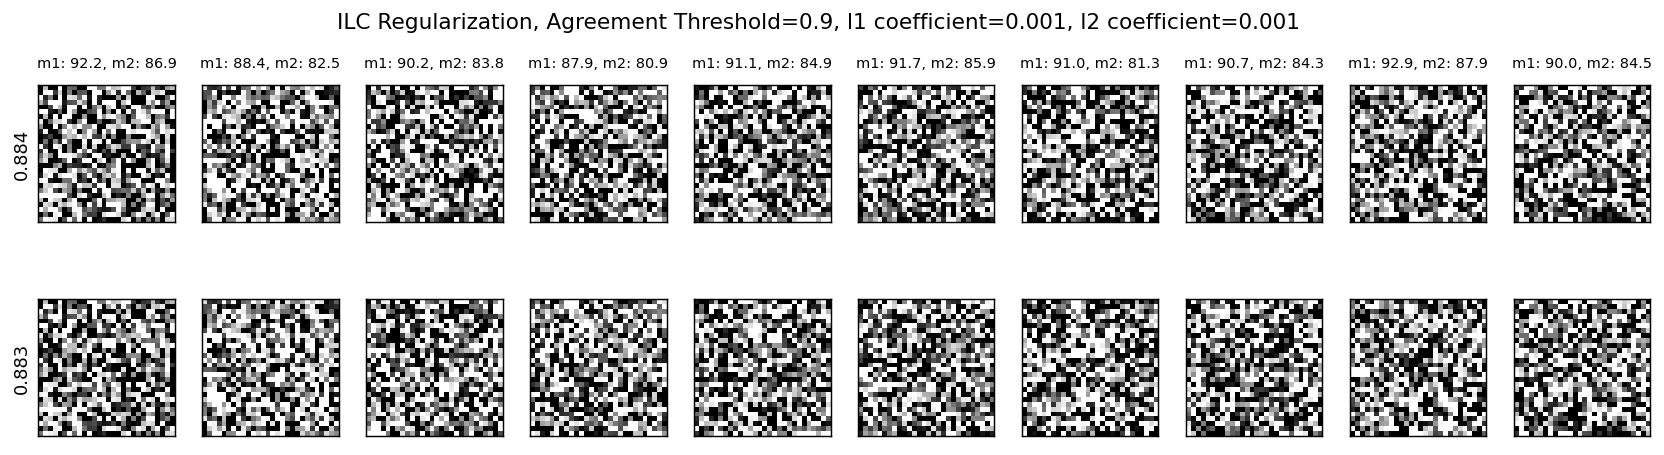

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

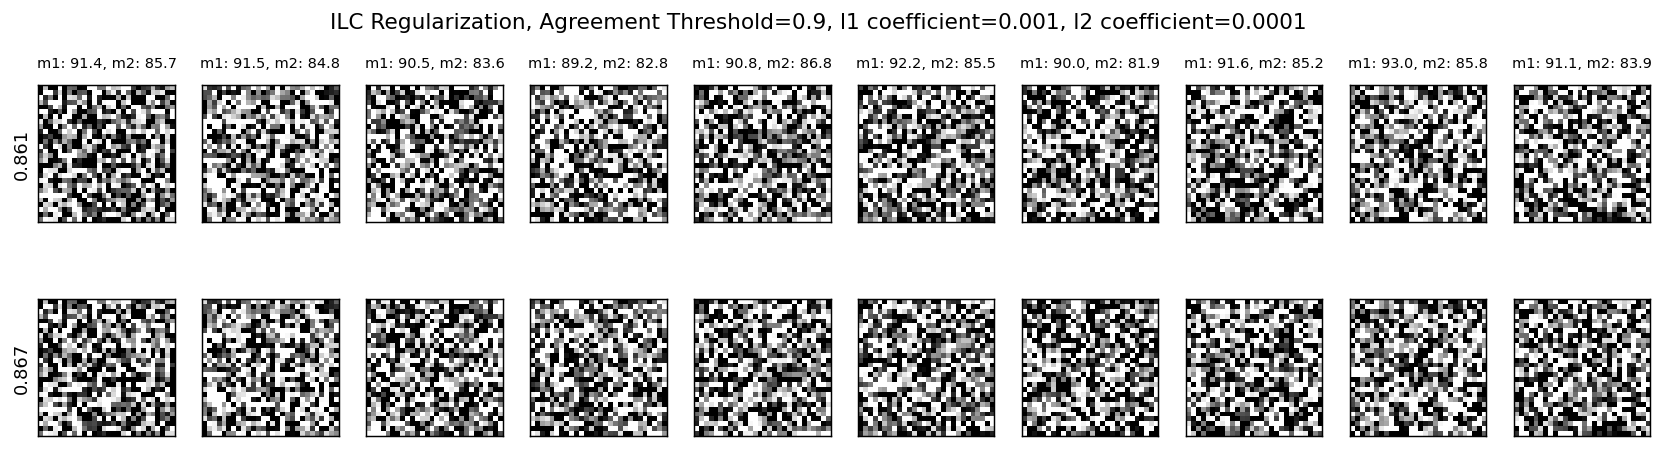

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

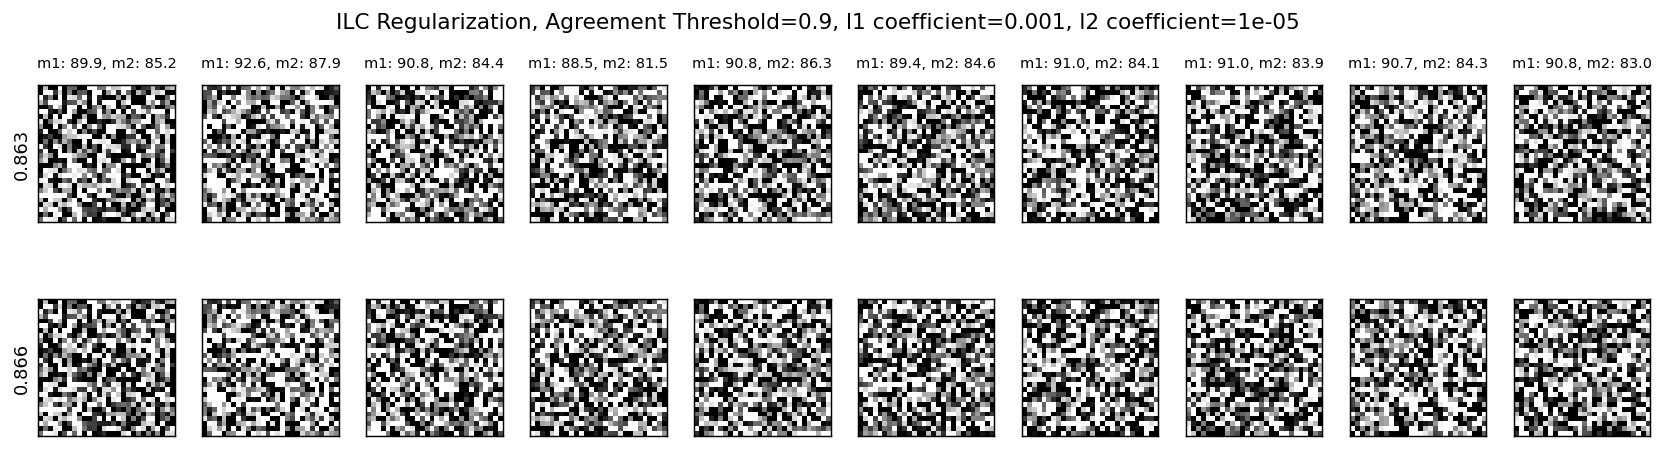

In [ ]:
from google.colab import files

# all = all_hps
n_envs = 2
setting_overlaps_method1 = np.zeros([len(all),10])
setting_overlaps_method2 = np.zeros([len(all),10])

num=0
for r in all:
  num += 1
  envs_elastic_net_params = r['params']
  fig, axes = plt.subplots(len(envs_elastic_net_params), 10, figsize=(16, 4), dpi=130, facecolor='w', edgecolor='k')
  # use global min / max to ensure all weights are shown on the same scale
  for m in range(n_envs):
      vmin, vmax = envs_elastic_net_params[m]['linear']['w'].min(), envs_elastic_net_params[m]['linear']['w'].max()
      for coef, ax in zip(envs_elastic_net_params[m]['linear']['w'].T, axes[m,:]):
          # print(coef.reshape(28, 28)[0,0])
          ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
                  vmax=.5 * vmax)
          ax.set_xticks(())
          ax.set_yticks(())
  '''
    1st method for calculating overlaps: map zeros to 0s, nonzeros to 1s. Get and the mappings. Sum over axis 1 and normalize: by total pixels or max # of nonzero elements.
  '''
  c = [np.abs(envs_elastic_net_params[i]['linear']['w'].T.round(3)) > 0.0 for i in range(n_envs)]
  c = np.array(c)
  overlapping_selectors = np.logical_and(c[0],c[1])
  denom = np.max(np.vstack((c[0].sum(axis=1),c[1].sum(axis=1))).T, axis=1)
  caps = overlapping_selectors.sum(axis=1)/denom # or /28**2
  caps[~np.isfinite(caps)] = 0
  caps_method1 = caps.round(3) * 100
  setting_overlaps_method1[num-1] = caps_method1

  '''
    2nd method for calculating overlaps: get a boolean mask for equal elements, get a boolean mask for nonzeros elements. And the masks.
    Sum over axis 1 and normalize: by total pixels or max # of nonzero elements.
  '''
  c = [envs_elastic_net_params[i]['linear']['w'].T.round(3) for i in range(n_envs)]
  c = np.array(c)
  equal_mask = (c[0] == c[1])
  nonzero_mask = (c[0] != 0)
  overlapping_selectors = np.logical_and(equal_mask,nonzero_mask)
  denom = np.max(np.vstack((np.count_nonzero(c[0],axis=1), np.count_nonzero(c[1],axis=1))).T,axis=1)
  caps = overlapping_selectors.sum(axis=1)/denom # or /28**2
  caps[~np.isfinite(caps)] = 0
  caps_method2 = caps.round(3) * 100
  setting_overlaps_method2[num-1] = caps_method2

  caps_method1[~np.isfinite(caps_method1)] = 0
  caps_method1 = caps_method1.round(3)
  
  caps_method2[~np.isfinite(caps_method2)] = 0
  caps_method2 = caps_method2.round(3)

  caps = ['m1: '+str(c1) +', m2: '+str(c2) for c1,c2 in zip(caps_method1,caps_method2)]

#   rows = np.array(r['acc']).round(3)
#   rows = ['in: '+str(c1) +', out: '+str(c2) for c1,c2 in zip(np.array(r['acc']).round(3),np.array(r['test_accuracy']).round(3))]
  rows = np.array([r['testing_accuracies'][0][-1], r['testing_accuracies'][1][-1]]).round(3)

  for ax, col in zip(axes[0], caps):
      ax.set_title(col,{'fontsize': 8})
  for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row)

  one = r['thresh']
  two = r['l1']
  three = r['l2']
  plt.suptitle('ILC Regularization, Agreement Threshold={}, l1 coefficient={}, l2 coefficient={}'.format(one,two,three))
  plt.savefig(f'{num}.png')
  files.download(f'{num}.png')
  plt.show()

### Plots for the whole run

In [59]:
# There are 54 settings for hps, for each we need to extract the thresh and l1 
# for fixed vals of l2. This function does that.
def idx_extrct(env_idx):
    agreement = all_hps[env_idx]['thresh']
    l1_coef = all_hps[env_idx]['l1']
    l2_coef = all_hps[env_idx]['l2']
    return agreement, l1_coef, l2_coef

setting_overlaps = setting_overlaps_method1
all_hps = all

print(setting_overlaps.shape)

"""
coordinate_1 is a list of dictionaries, each dictionary corresponds to a digit
so coordinate_1 is a list of 10 dictionaries. Each dictionary holds these keys:
'digit', 'x', 'y', 'z'. 'digit' is obvious. 'x','y','z' hold the values for 3d
plots, so 'x' holds 18 values for agreement thresholds, 'y' 18 vals for log of 
l1 coefs, 'z' 18 vals for overlap scores. Why 18? Remember that our hps are these:

at = [0.0, 0.2, 0.4, 0.5, 0.7, 0.9]
ll1 = [1e-1, 1e-2, 1e-3]
ll2 = [1e-3, 1e-4, 1e-5]

so 6 possible vals for at, 3 for l1, 3 for l2. In total there are 6x3x3=54 configs.
But when l2 is fixed (3D plots are for fixed l2), there remain 6x3=18 combination
of values for agreement and thresh. That's why 'x','y','z' have 18 elements for 
each digit in coordinate_1. Now coordinate_1 holds the dicts for l2=0.001. The same
goes for coordinates_2 and coordinates_3. They hold the the coordinates for digits
in settings where l2=1e-4 and l2=1e-5, respectively.
"""


""" Getting the coordinates for plotting overlap scores"""

# There are 54 envs.  
# threshold
coordinates_1 = []
coordinates_2 = []
coordinates_3 = []

for digit in range(10):
    
    x_1 = []
    y_1 = []
    z_1 = []

    x_2 = []
    y_2 = []
    z_2 = []

    x_3 = []
    y_3 = []
    z_3 = []

    for counter, hp in enumerate(all_hps):
        # l2 coef = 0.001
        if np.mod(counter,3) == 0:
            thresh, l1,_ = idx_extrct(counter)
            x_1.append(thresh)
            y_1.append(np.log10(l1))
            z_1.append(setting_overlaps[counter, digit])
                
        
            
        # l2 coef = 1e-4
        if np.mod(counter,3) == 1:
            thresh, l1,_ = idx_extrct(counter)
            x_2.append(thresh)
            y_2.append(np.log10(l1))
            z_2.append(setting_overlaps[counter, digit])

        

        # l2 coef = 1e-5
        if np.mod(counter,3) == 2:
            thresh, l1,_ = idx_extrct(counter)
            x_3.append(thresh)
            y_3.append(np.log10(l1))
            z_3.append(setting_overlaps[counter, digit])

        
    coordinates_1.append({'digit': digit, 'x':x_1,'y':y_1,'z':z_1})
    coordinates_2.append({'digit': digit, 'x':x_2,'y':y_2,'z':z_2})
    coordinates_3.append({'digit': digit, 'x':x_3,'y':y_3,'z':z_3})


""" Getting the coordinates for plotting test accuracies"""

# There are 54 envs.  
# threshold
coordinates_test_1 = []
coordinates_test_2 = []
coordinates_test_3 = []
  
x_1 = []
y_1 = []
z_1 = []
z_1_in_dist = []

x_2 = []
y_2 = []
z_2 = []
z_2_in_dist = []

x_3 = []
y_3 = []
z_3 = []
z_3_in_dist = []

for counter, hp in enumerate(all_hps):

    # l2 coef = 0.001
    if np.mod(counter,3) == 0:
        thresh, l1,_ = idx_extrct(counter)
        x_1.append(thresh)
        y_1.append(np.log10(l1))
        z_1.append(0.5*(jax.device_get(hp['testing_accuracies'][0][-1])+jax.device_get(hp['testing_accuracies'][1][-1])))
        z_1_in_dist.append(0.5*(jax.device_get(hp['training_accuracies'][0][-1])+jax.device_get(hp['training_accuracies'][1][-1])))
            
    
        
    # l2 coef = 1e-4
    if np.mod(counter,3) == 1:
        thresh, l1,_ = idx_extrct(counter)
        x_2.append(thresh)
        y_2.append(np.log10(l1))
        z_2.append(0.5*(jax.device_get(hp['testing_accuracies'][0][-1])+jax.device_get(hp['testing_accuracies'][1][-1])))
        z_2_in_dist.append(0.5*(jax.device_get(hp['training_accuracies'][0][-1])+jax.device_get(hp['training_accuracies'][1][-1])))

    

    # l2 coef = 1e-5
    if np.mod(counter,3) == 2:
        thresh, l1,_ = idx_extrct(counter)
        x_3.append(thresh)
        y_3.append(np.log10(l1))
        z_3.append(0.5*(jax.device_get(hp['testing_accuracies'][0][-1])+jax.device_get(hp['testing_accuracies'][1][-1])))
        z_3_in_dist.append(0.5*(jax.device_get(hp['training_accuracies'][0][-1])+jax.device_get(hp['training_accuracies'][1][-1])))

    
coordinates_test_1 = {'l2': 1e-3, 'x':x_1,'y':y_1,'z':z_1,'z_in_dist':z_1_in_dist}
coordinates_test_2 = {'l2': 1e-4, 'x':x_2,'y':y_2,'z':z_2,'z_in_dist':z_2_in_dist}
coordinates_test_3 = {'l2': 1e-5, 'x':x_3,'y':y_3,'z':z_3,'z_in_dist':z_3_in_dist}



""" Getting the coordinates and colors for plotting test accuracies vs all params"""

coordinates_logl1 = []
coordinates_logl2 = []
coordinates_agth = []
coloring_overlap = []
coloring_testacc = []


for counter, hp in enumerate(all_hps):


    thresh, l1,l2 = idx_extrct(counter)
    coordinates_logl1.append(np.log10(l1))
    coordinates_logl2.append(np.log10(l2))
    coordinates_agth.append(thresh)
    coloring_overlap.append(np.mean(setting_overlaps[counter]))
    coloring_testacc.append(0.5*(jax.device_get(hp['testing_accuracies'][0][-1])+jax.device_get(hp['testing_accuracies'][1][-1])))


(54, 10)


In [ ]:
# print(coordinates_1[0]['y'])
# x = [coordinates_test_1['x'][n] for n in range(18) if np.mod(n,3) == 0]
# print(x)
coordinates_test_1['z']

[0.10099999606609344,
 0.8073999881744385,
 0.9060499668121338,
 0.48969998955726624,
 0.852899968624115,
 0.902400016784668,
 0.7009999752044678,
 0.8504999876022339,
 0.8684999942779541,
 0.7213499546051025,
 0.767549991607666,
 0.7895499467849731,
 0.11089999973773956,
 0.6682000160217285,
 0.5895999670028687,
 0.12174999713897705,
 0.7792999744415283,
 0.8833999633789062]

In [ ]:
x = [coordinates_1[digit]['x'][n] for n in range(18) if np.mod(n,3) == 0]
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
print(colors)

{'b': (0, 0, 1), 'g': (0, 0.5, 0), 'r': (1, 0, 0), 'c': (0, 0.75, 0.75), 'm': (0.75, 0, 0.75), 'y': (0.75, 0.75, 0), 'k': (0, 0, 0), 'w': (1, 1, 1), 'aliceblue': '#F0F8FF', 'antiquewhite': '#FAEBD7', 'aqua': '#00FFFF', 'aquamarine': '#7FFFD4', 'azure': '#F0FFFF', 'beige': '#F5F5DC', 'bisque': '#FFE4C4', 'black': '#000000', 'blanchedalmond': '#FFEBCD', 'blue': '#0000FF', 'blueviolet': '#8A2BE2', 'brown': '#A52A2A', 'burlywood': '#DEB887', 'cadetblue': '#5F9EA0', 'chartreuse': '#7FFF00', 'chocolate': '#D2691E', 'coral': '#FF7F50', 'cornflowerblue': '#6495ED', 'cornsilk': '#FFF8DC', 'crimson': '#DC143C', 'cyan': '#00FFFF', 'darkblue': '#00008B', 'darkcyan': '#008B8B', 'darkgoldenrod': '#B8860B', 'darkgray': '#A9A9A9', 'darkgreen': '#006400', 'darkgrey': '#A9A9A9', 'darkkhaki': '#BDB76B', 'darkmagenta': '#8B008B', 'darkolivegreen': '#556B2F', 'darkorange': '#FF8C00', 'darkorchid': '#9932CC', 'darkred': '#8B0000', 'darksalmon': '#E9967A', 'darkseagreen': '#8FBC8F', 'darkslateblue': '#483D8B

In [60]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# import plotly.plotly as py
# import plotly.tools as tls
# from plotly.graph_objs import *

########## l2=0.001 ##########
# np_data = []
# df_digits = []

fig = go.Figure()

colors = ["brown","blue","orange","green","magenta","cyan","yellow","violet","skyblue","cornflowerblue"] # "blue" if digit == 7 else "red"

# #################### Fig. 1 overlap #################### #
for digit in [7,8]: # This is to show that you can plot the evolution of whatever digits you want.
    for m in range(3):
        x = [coordinates_1[digit]['x'][n] for n in range(18) if np.mod(n,3) == m]
        y = [coordinates_1[digit]['y'][n] for n in range(18) if np.mod(n,3) == m]
        z = [coordinates_1[digit]['z'][n] for n in range(18) if np.mod(n,3) == m]
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color=colors[digit]), name=str(digit)))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Overlap Score'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
# fig.update_layout(title_text='', title_font_size=10)
fig.show()

# #################### Fig. 2 overlap #################### #
fig = go.Figure()

for digit in range(10):
    for m in range(3):
        x = [coordinates_1[digit]['x'][n] for n in range(18) if np.mod(n,3) == m]
        y = [coordinates_1[digit]['y'][n] for n in range(18) if np.mod(n,3) == m]
        z = [coordinates_1[digit]['z'][n] for n in range(18) if np.mod(n,3) == m]
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color=colors[digit]), name=str(digit)))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Overlap Score'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# ------------------------ #

# #################### Fig. 3 Test Acc #################### #

fig = go.Figure()

for m in range(3):
    x = [coordinates_test_1['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_1['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_1['z'][n]*100 for n in range(18) if np.mod(n,3) == m]
    # print(x)
    # print(y)
    # print(z)
    # break
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Test Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# In-dist

fig = go.Figure()

for m in range(3):
    x = [coordinates_test_1['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_1['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_1['z_in_dist'][n]*100 for n in range(18) if np.mod(n,3) == m]
    # print(x)
    # print(y)
    # print(z)
    # break
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='In-dist Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


# ########## l2=1e-4 ##########

# #################### Fig. 4 overlap #################### #
fig = go.Figure()

for digit in range(10):
    for m in range(3):
        x = [coordinates_2[digit]['x'][n] for n in range(18) if np.mod(n,3) == m]
        y = [coordinates_2[digit]['y'][n] for n in range(18) if np.mod(n,3) == m]
        z = [coordinates_2[digit]['z'][n] for n in range(18) if np.mod(n,3) == m]
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color=colors[digit]), name=str(digit)))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Overlap Score'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


# fig = go.Figure()
# for digit in range(10):

#     fig.add_trace(go.Scatter3d(x=coordinates_2[digit]['x'], y=coordinates_2[digit]['y'], z=coordinates_2[digit]['z'], mode='markers'))#(df_digits[digit], x='agreement', y='log l1', z='overlap'))
    

# fig.update_layout(scene = dict(
#                     xaxis_title='Agreement Threshold',
#                     yaxis_title='Log L1 Coef',
#                     zaxis_title='Overlap Score'),
#                     width=700,
#                     margin=dict(r=20, b=10, l=10, t=10))

# fig.show()


# #################### Fig. 5 Test Acc #################### #
fig = go.Figure()

for m in range(3):
    x = [coordinates_test_2['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_2['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_2['z'][n]*100 for n in range(18) if np.mod(n,3) == m]
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))


fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Test Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# In-dist

fig = go.Figure()

for m in range(3):
    x = [coordinates_test_2['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_2['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_2['z_in_dist'][n]*100 for n in range(18) if np.mod(n,3) == m]
    # print(x)
    # print(y)
    # print(z)
    # break
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='In-dist Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# ########## l2=1e-5 ##########

# #################### Fig. 6 overlap #################### #
fig = go.Figure()

for digit in range(10):
    for m in range(3):
        x = [coordinates_3[digit]['x'][n] for n in range(18) if np.mod(n,3) == m]
        y = [coordinates_3[digit]['y'][n] for n in range(18) if np.mod(n,3) == m]
        z = [coordinates_3[digit]['z'][n] for n in range(18) if np.mod(n,3) == m]
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color=colors[digit]), name=str(digit)))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Overlap Score'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


# fig = go.Figure()
# for digit in range(10):

#     fig.add_trace(go.Scatter3d(x=coordinates_3[digit]['x'], y=coordinates_3[digit]['y'], z=coordinates_3[digit]['z'], mode='markers'))#(df_digits[digit], x='agreement', y='log l1', z='overlap'))
    

# fig.update_layout(scene = dict(
#                     xaxis_title='Agreement Threshold',
#                     yaxis_title='Log L1 Coef',
#                     zaxis_title='Overlap Score'),
#                     width=700,
#                     margin=dict(r=20, b=10, l=10, t=10))
  
# fig.show()


# #################### Fig. 7 Test Acc #################### #
fig = go.Figure()

for m in range(3):
    x = [coordinates_test_3['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_3['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_3['z'][n]*100 for n in range(18) if np.mod(n,3) == m]
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))


fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='Test Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


# In-dist

fig = go.Figure()

for m in range(3):
    x = [coordinates_test_3['x'][n] for n in range(18) if np.mod(n,3) == m]
    y = [coordinates_test_3['y'][n] for n in range(18) if np.mod(n,3) == m]
    z = [coordinates_test_3['z_in_dist'][n]*100 for n in range(18) if np.mod(n,3) == m]
    # print(x)
    # print(y)
    # print(z)
    # break
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines'
    # , line=dict(color="blue" if digit == 7 else "red")
    ))
 



fig.update_layout(scene = dict(
                    xaxis_title='Agreement Threshold',
                    yaxis_title='Log L1 Coef',
                    zaxis_title='In-dist Accuracy'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [58]:
# #################### Fig. 8 All Params (overlap acc colored) #################### #
fig = go.Figure()
x = coordinates_logl1
y = coordinates_logl2
z = coordinates_agth
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
    size=6,
    color=coloring_overlap,                # set color to an array/list of desired values
    colorscale='Viridis',
    opacity=0.8
)
# , line=dict(color="blue" if digit == 7 else "red")
))


fig.update_layout(scene = dict(
                    xaxis_title='Log L1 Coef',
                    yaxis_title='Log L2 Coef',
                    zaxis_title='Agreement Threshold'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# #################### Fig. 9 All Params (test acc colored) #################### #
fig = go.Figure()
x = coordinates_logl1
y = coordinates_logl2
z = coordinates_agth
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
    size=6,
    color=coloring_testacc,                # set color to an array/list of desired values
    colorscale='Viridis',
    opacity=0.8
)
# , line=dict(color="blue" if digit == 7 else "red")
))


fig.update_layout(scene = dict(
                    xaxis_title='Log L1 Coef',
                    yaxis_title='Log L2 Coef',
                    zaxis_title='Agreement Threshold'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [ ]:
!pip freeze > requirements.txt